Mar 6

Visualize how well the class embeddings attend on words and
sentences. The expected result would be that the “married”
class embedding, for example, attends heavily on words and
sentences related to marriage like “married”, “husband”, “wife”, etc.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime
from pathlib import Path
from typing import List, Tuple

import pandas as pd
import torch
from IPython.core.display import display
from sklearn.metrics import precision_score, recall_score, f1_score
from torch import tensor, Tensor
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from classifier import Classifier, debug
from dao.ower.ower_dir import Sample, OwerDir
from util import log_tensor, plot_tensor

pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 2)

# Config

In [2]:
ower_dataset = 'ower-v3-fb-irt-3'
class_count = 4
sent_count = 3

# vectors = None
# vectors = 'charngram.100d'
# vectors = 'fasttext.en.300d'
# vectors = 'fasttext.simple.300d'
# vectors = 'glove.42B.300d'
# vectors = 'glove.840B.300d'
# vectors = 'glove.twitter.27B.25d'
# vectors = 'glove.twitter.27B.50d'
# vectors = 'glove.twitter.27B.100d'
vectors = 'glove.twitter.27B.200d'
# vectors = 'glove.6B.50d'
# vectors = 'glove.6B.100d'
# vectors = 'glove.6B.200d'
# vectors = 'glove.6B.300d'

emb_size = None
# emb_size = 200

batch_size = 1024
sent_len = 64

class_weight = 4
lr = 0.1
epoch_count = 50

log_dir = 'runs/' + datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + \
          f'_{ower_dataset}_emb-{emb_size}'

# 1 Build train/valid DataLoaders

In [3]:
ower_dir_path = Path('data/ower/ower-v3-fb-irt-3')
ower_dir = OwerDir('OWER Dataset Directory', ower_dir_path, class_count, sent_count)
ower_dir.check()

train_set: List[Sample]
valid_set: List[Sample]

train_set, valid_set, _, vocab = ower_dir.read_datasets(vectors=vectors)

#
# Create dataloaders
#

def generate_batch(batch: List[Sample]) -> Tuple[Tensor, Tensor]:

    _, gt_classes_batch, tok_lists_batch = zip(*batch)

    cropped_sents_batch = [[sent[:sent_len]
                            for sent in sents] for sents in tok_lists_batch]

    padded_sents_batch = [[sent + [0] * (sent_len - len(sent))
                           for sent in sents] for sents in cropped_sents_batch]

    return tensor(padded_sents_batch), tensor(gt_classes_batch)

train_loader = DataLoader(train_set, batch_size=batch_size, collate_fn=generate_batch, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, collate_fn=generate_batch)

c:\users\tobias\documents\hsrm\master\thesis\thesis-tools\venv\lib\site-packages\torchtext\data\field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
c:\users\tobias\documents\hsrm\master\thesis\thesis-tools\venv\lib\site-packages\torchtext\data\example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
c:\users\tobias\documents\hsrm\master\thesis\thesis-tools\venv\lib\site-packages\torchtext\data\example.py:78: UserWarning: Example clas

# 2 Create classifier

In [4]:
if vocab.vectors is None:
    classifier = Classifier.from_random(len(vocab), emb_size, class_count)
else:
    classifier = Classifier.from_pre_trained(vocab, class_count)

print(classifier)

Classifier(
  (embedding_bag): EmbeddingBag(112490, 200, mode=mean)
)


# 3 Training

entity                                              logits             p  \
0    foo     [-0.18207893, 1.0759671, 0.08488768, 1.4831603]  [0, 1, 1, 1]   
1    foo     [1.1834459, 0.87098706, 0.3881995, -0.43594074]  [1, 1, 1, 0]   
2    foo     [-0.7848014, 1.2120011, 0.12141499, 0.52697444]  [0, 1, 1, 1]   
3    foo      [-1.2503839, 1.1608031, -0.2243782, 0.8661229]  [0, 1, 0, 1]   
4    foo      [-0.1355665, 1.0217667, 0.23454693, -1.384882]  [0, 1, 1, 0]   
5    foo  [-0.095116496, 0.92569613, 0.21779552, -1.5313118]  [0, 1, 1, 0]   
6    foo     [-0.20898163, 1.3286523, 0.07031903, 0.8412098]  [0, 1, 1, 1]   
7    foo       [-0.2205492, 1.0821941, 0.1274809, 0.6284853]  [0, 1, 1, 1]   

             gt  \
0  [0, 1, 1, 1]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  sents  
0                [[in, september,, amy, hargreaves,, kate, walsh, and, derek, luke, were, cast., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [on, september, 19,, 2019,, philippine, leroy, beaulieu,, lucas, bravo,, samuel, arnold,, camille, razat,, and, bruno, gouery, joined, cast, in, starring, roles, while, kate, walsh,, william, abadie,, and, arnaud, viard, were, cast, in, recurring, roles., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [kate, walsh, played, addison, montgomery,, obstetrician-gynecologist, and, neonatal, surgeon,, who, comes, to, terms, with, her, husband, derek, shepherd's, desire, to, divorce,, while, dealing, with, the, arrival, of, her, former, lover., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                                                [[on, 22, february, 2020,, dreamworks, films, are, now, returned, to, nine, network, after, 8, years, was, absence,, as, well, as, paramount, films, (viacomcbs, films), is, now, moved, from, 10, to, nine, becau

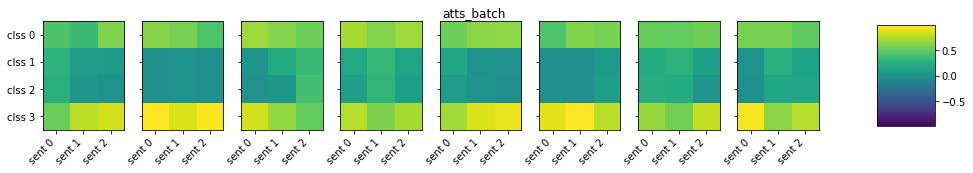

entity                                              logits             p  \
0    foo    [-4.0815606, -0.45880076, -1.895453, -3.8381982]  [0, 0, 0, 0]   
1    foo      [1.316345, -0.3770557, -1.0801954, -2.7888026]  [1, 0, 0, 0]   
2    foo     [1.2904017, -0.34176433, -0.6573512, -3.027904]  [1, 0, 0, 0]   
3    foo    [1.8493567, -0.57029957, -0.43573526, 1.8385584]  [1, 0, 0, 1]   
4    foo   [-3.8956923, -0.47754255, -1.6227295, -2.2129912]  [0, 0, 0, 0]   
5    foo     [-2.04076, -0.8173789, -1.8930856, -0.29998267]  [0, 0, 0, 0]   
6    foo  [-1.9275393, -1.0819156, -1.9286611, -0.100456595]  [0, 0, 0, 0]   
7    foo    [0.66611725, -0.6150769, -0.21904457, 2.3180962]  [1, 0, 0, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robe

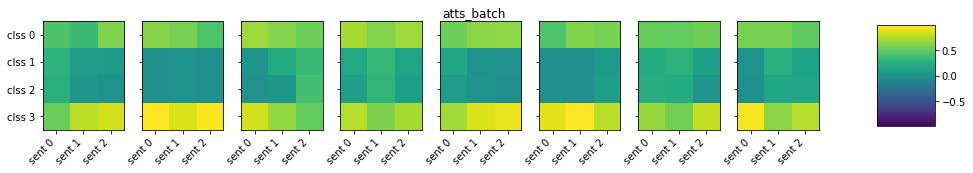

Epoch 0


c:\users\tobias\documents\hsrm\master\thesis\thesis-tools\venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


entity                                             logits             p  \
0    foo    [-2.5289345, -1.02999, -1.1915493, -0.32072735]  [0, 0, 0, 0]   
1    foo   [-4.1449757, -1.0311708, -3.0373452, -4.1233907]  [0, 0, 0, 0]   
2    foo   [-6.1568723, -0.37223196, -2.3895242, -6.023169]  [0, 0, 0, 0]   
3    foo    [-3.1515467, -0.5211371, -1.7354516, -3.016334]  [0, 0, 0, 0]   
4    foo   [-1.6909449, -0.98416984, -2.1772523, 0.7025836]  [0, 0, 0, 1]   
5    foo    [-5.345646, -0.37211204, -1.3126084, -5.052726]  [0, 0, 0, 0]   
6    foo   [-0.5466795, -0.61087686, -1.0946705, 1.2526819]  [0, 0, 0, 1]   
7    foo  [-4.4397435, -0.58637476, -3.3217366, -4.6648364]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [1, 1, 0, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         sents  
0                  [[jones, signed, with, tennessee, in, a, class, that, included, alan, cockrell,, reggie, mckenzie,, raleigh, mckenzie,, carl, zander, and, alvin, toles., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [hobby, played, college, football, at, the, university, of, tennessee, under, head, coach, johnny, majors., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [tennessee, volunteers, football, guide, (university, of, tennessee,, 1981),, p., 57., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                                               [[the, lei, feng, memorial, hall, (in, his, birthplace,, now, named, for, him,, leifeng), and, lei, feng, statue, are, located, in, changsha., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk

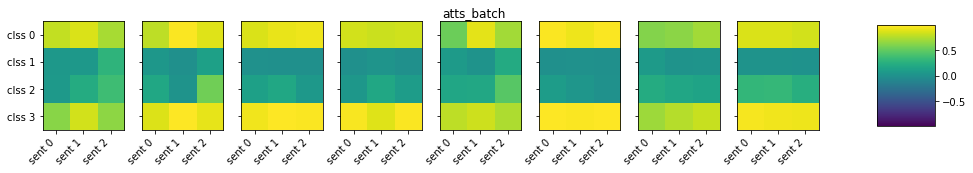

entity                                            logits             p  \
0    foo   [-4.1797724, -1.8147521, -2.9729877, -5.755674]  [0, 0, 0, 0]   
1    foo  [-0.21168745, -1.0791037, -1.055508, -3.1967745]  [0, 0, 0, 0]   
2    foo   [3.0392368, -0.9444765, -0.2701548, -3.4082985]  [1, 0, 0, 0]   
3    foo    [1.9136124, -1.0005324, 0.09702359, 2.2525425]  [1, 0, 1, 1]   
4    foo   [-3.2393053, -1.6942785, -2.535499, -3.6896877]  [0, 0, 0, 0]   
5    foo   [-1.879564, -2.2698727, -1.8483368, -1.7372723]  [0, 0, 0, 0]   
6    foo   [-1.5371935, -3.348206, -2.1557856, -1.3205645]  [0, 0, 0, 0]   
7    foo     [1.2981312, -1.0058987, 0.19183154, 3.033813]  [1, 0, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

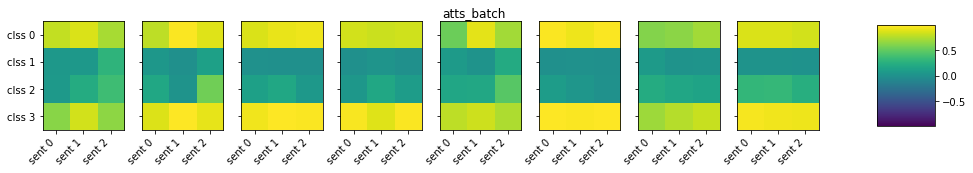

Epoch 1


c:\users\tobias\documents\hsrm\master\thesis\thesis-tools\venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\tobias\documents\hsrm\master\thesis\thesis-tools\venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


entity                                              logits             p  \
0    foo   [0.42515814, -1.8859513, -0.73328125, -2.2113411]  [1, 0, 0, 0]   
1    foo    [-2.2196004, -3.2487936, -2.3998487, -0.9358425]  [0, 0, 0, 0]   
2    foo     [-2.2843697, -1.6355014, -1.935333, -1.8648539]  [0, 0, 0, 0]   
3    foo  [-0.21991599, -1.1864681, -0.62863314, -1.1297503]  [0, 0, 0, 0]   
4    foo     [-2.549404, -2.5215468, -2.1149511, -3.4175987]  [0, 0, 0, 0]   
5    foo      [-3.825828, -2.034411, -2.5534685, -1.0396242]  [0, 0, 0, 0]   
6    foo    [-1.3183818, -2.0386825, -1.4692172, -1.0052722]  [0, 0, 0, 0]   
7    foo     [-2.2499719, -2.2460103, -2.4623077, -2.499749]  [0, 0, 0, 0]   

             gt  \
0  [1, 1, 1, 1]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [1, 1, 1, 1]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             sents  
0                                                                    [[otto, preminger, directed, a, 1960, film, based, on, the, novel,, featuring, paul, newman, as, ari, ben, canaan., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [in, april, 1956,, preminger, and, others, were, sued, by, algren,, who, was, seeking, an, injunction, to, keep, him, from, claiming, ownership, of, the, property, as, "an, otto, preminger, film"., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [opening, on, december, 18,, 1968,, at, loews, crest, theater, in, los, angeles,, amblin', shared, a, double, bill, with, otto, preminger's, skidoo., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                     [[du-pont, was, born, on, 26, june, 1988, in, manzini,, swaziland., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>,

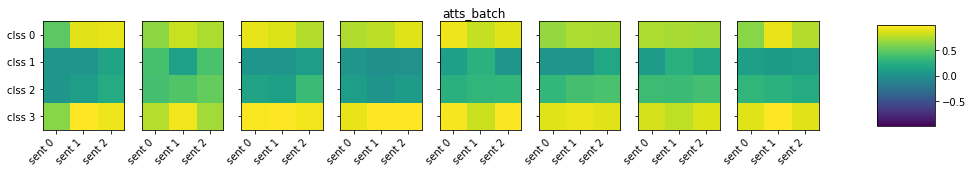

entity                                            logits             p  \
0    foo    [-4.161638, -2.1364152, -3.3310206, -6.681718]  [0, 0, 0, 0]   
1    foo   [-0.5527133, -0.9447286, -0.8176561, -4.238151]  [0, 0, 0, 0]   
2    foo    [3.935934, -0.8154485, 0.13660142, -4.1206913]  [1, 0, 1, 0]   
3    foo    [2.5896854, -0.80858296, 0.48448986, 1.548521]  [1, 0, 1, 1]   
4    foo   [-2.7983003, -2.1379085, -2.777715, -4.6304083]  [0, 0, 0, 0]   
5    foo   [-2.0016065, -2.4966652, -1.643698, -2.5955243]  [0, 0, 0, 0]   
6    foo  [-1.2265853, -3.9243572, -1.9154551, -2.1048782]  [0, 0, 0, 0]   
7    foo     [1.7804935, -0.7949984, 0.5933349, 2.9266636]  [1, 0, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

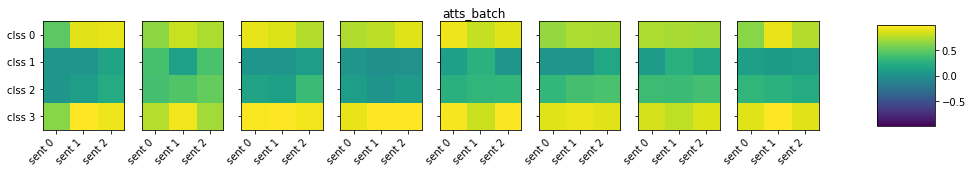

Epoch 2


c:\users\tobias\documents\hsrm\master\thesis\thesis-tools\venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\tobias\documents\hsrm\master\thesis\thesis-tools\venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


entity                                            logits             p  \
0    foo    [-3.6201348, -3.847259, -3.4182975, -4.817891]  [0, 0, 0, 0]   
1    foo     [-4.0361333, -3.917511, -2.948467, -3.793781]  [0, 0, 0, 0]   
2    foo     [-5.48546, -11.384976, -8.727403, -5.8974795]  [0, 0, 0, 0]   
3    foo    [-3.9538143, -7.06983, -5.3463492, -4.1020656]  [0, 0, 0, 0]   
4    foo   [-3.6860342, -1.9544299, -4.453701, -6.1080675]  [0, 0, 0, 0]   
5    foo  [-3.2271354, -3.0944977, -6.3708253, -2.9346976]  [0, 0, 0, 0]   
6    foo    [-7.008436, -12.178597, -10.350255, -7.753654]  [0, 0, 0, 0]   
7    foo  [0.5226929, -1.3391464, -0.51524824, -2.8875473]  [1, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 1, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 sents  
0  [[the, film, was, usually, shown, on, television, using, the, standard, 1.33:1, aspect, ratio, version, that, fills, a, standard, television, screen, rather, than, the, cinemascope, version., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [definity's, imaging, unit, exploits, the, sub-pixel, structure, of, the, lcd, in, order, to, record, anamorphic, "cinemascope", material, without, loss, of, horizontal, image, information:, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, film, was, photographed, in, cinemascope, format, and, was, converted, to, 70, mm, blow-up, prints, with, 6-track, magnetic, stereo, sound, during, post-production., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                                                           [[she, is, a, columnist, from, 2009, to, 2013, for, canal+35's, la, matinale., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, 

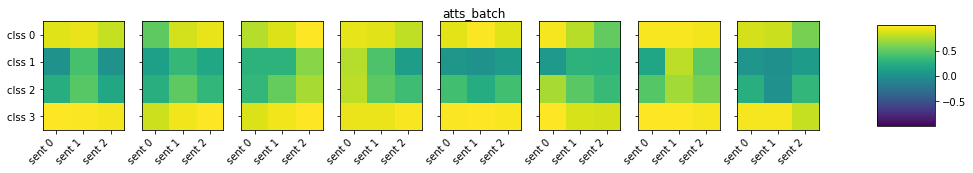

entity                                            logits             p  \
0    foo    [-4.673295, -2.150484, -2.8468485, -6.2485876]  [0, 0, 0, 0]   
1    foo  [-1.1185609, -0.668851, -0.39477193, -3.9687657]  [0, 0, 0, 0]   
2    foo   [3.414177, -0.50011265, 0.38686678, -3.8351464]  [1, 0, 1, 0]   
3    foo    [2.5554385, -0.49315733, 0.6626837, 1.2270434]  [1, 0, 1, 1]   
4    foo   [-3.4167495, -2.2160282, -2.7067127, -4.623764]  [0, 0, 0, 0]   
5    foo    [-2.4245791, -2.484108, -1.694336, -2.7815053]  [0, 0, 0, 0]   
6    foo    [-1.5064485, -3.73453, -1.7927753, -2.2506151]  [0, 0, 0, 0]   
7    foo       [1.4809188, -0.4742074, 0.8196624, 3.36765]  [1, 0, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

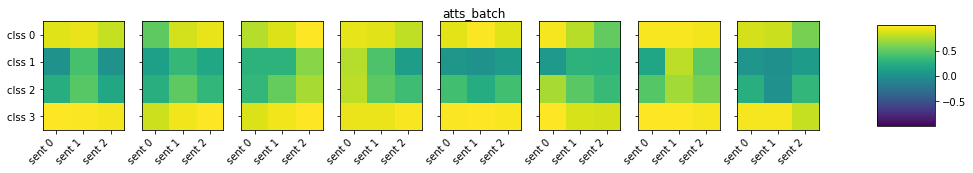

Epoch 3


c:\users\tobias\documents\hsrm\master\thesis\thesis-tools\venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\tobias\documents\hsrm\master\thesis\thesis-tools\venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


entity                                            logits             p  \
0    foo   [2.0184765, -0.58978504, 0.33615676, 0.9564957]  [1, 0, 1, 1]   
1    foo    [-2.63909, -0.5583805, -0.2432819, -3.4078388]  [0, 0, 0, 0]   
2    foo      [-4.672603, -3.0761771, -6.29204, -3.246952]  [0, 0, 0, 0]   
3    foo     [-3.0082297, -2.936883, -5.281709, -3.943079]  [0, 0, 0, 0]   
4    foo      [-9.371765, -7.905793, -5.950074, -8.854816]  [0, 0, 0, 0]   
5    foo    [-0.4482454, -1.0699296, -0.6395278, -1.26672]  [0, 0, 0, 0]   
6    foo    [-2.9063845, -1.5532794, -2.728755, -1.793441]  [0, 0, 0, 0]   
7    foo  [0.012537599, -0.46992195, 0.9052679, 1.1192989]  [1, 0, 1, 1]   

             gt  \
0  [1, 1, 0, 1]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 1, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                sents  
0                                                                       [[the, film, stars, ben, barnes, as, neil, mccormick,, robert, sheehan, as, ivan, mccormick, and, martin, mccann, as, irish, singer, bono., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [examples, including, brian, wilson's, "beached, whale", era,, bono's, macphisto, character,, and, kurt, cobain's, collaboration, with, william, s., burroughs., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [lead, vocalist, bono, frequently, refers, to, it, as, one, of, his, favorite, songs, of, the, band's., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                                                                            [[according, to, the, directory, of, world, cinema:, american, hollywood, by, lincoln, geraghty,, belle, was, inspired, by, actress, judy, g

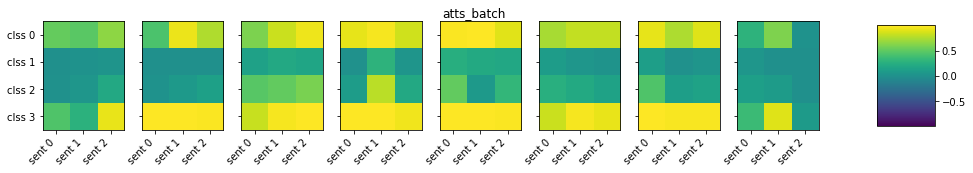

entity                                            logits             p  \
0    foo    [-4.155205, -4.8526206, -2.804544, -6.1193905]  [0, 0, 0, 0]   
1    foo  [-1.2061771, -1.216533, -0.20600855, -3.6958055]  [0, 0, 0, 0]   
2    foo      [3.0515828, -0.2276689, 0.5053499, -4.09721]  [1, 0, 1, 0]   
3    foo     [2.2326715, -0.19831224, 0.763712, 0.8646568]  [1, 0, 1, 1]   
4    foo  [-3.2980418, -3.8617706, -3.0658646, -5.0046787]  [0, 0, 0, 0]   
5    foo   [-2.4573522, -3.641488, -2.0781415, -3.0921068]  [0, 0, 0, 0]   
6    foo    [-1.2993754, -4.1317663, -1.927309, -2.519147]  [0, 0, 0, 0]   
7    foo   [1.8892388, -0.16355737, 0.98255485, 3.1049533]  [1, 0, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

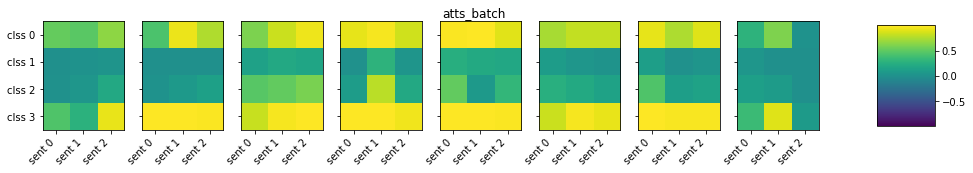

Epoch 4


c:\users\tobias\documents\hsrm\master\thesis\thesis-tools\venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\tobias\documents\hsrm\master\thesis\thesis-tools\venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


entity                                               logits             p  \
0    foo       [-2.4059272, -4.998664, -4.119956, -2.7243907]  [0, 0, 0, 0]   
1    foo     [-1.5905126, -2.1860116, -3.6551247, -5.6274776]  [0, 0, 0, 0]   
2    foo       [-2.4877732, -4.567542, -3.909648, -3.7628007]  [0, 0, 0, 0]   
3    foo  [-0.32638502, -0.97365373, -0.61887956, -1.4624542]  [0, 0, 0, 0]   
4    foo      [-7.490196, -17.142813, -12.044498, -7.4759808]  [0, 0, 0, 0]   
5    foo    [-0.7877334, -0.76514465, -1.4029593, -1.2294792]  [0, 0, 0, 0]   
6    foo   [1.0473342, -0.40154523, 0.69682515, -0.022883207]  [1, 0, 1, 0]   
7    foo       [-5.7730722, -13.794831, -5.014207, -5.614012]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [1, 1, 0, 1]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [1, 0, 1, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   sents  
0  [[little, is, known, about, the, anonymous, artists, who, produced, the, tijuana, bibles., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [after, they, become, bored,, the, videographer, suggests, they, continue, the, film, shoot, in, tijuana,, where, they, subsequently, become, lost, after, buying, fireworks., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, tijuana, cartel, (spanish:, cártel, de, tijuana), or, arellano-félix, organization, (spanish:, cártel, arellano, félix,, caf), is, a, mexican, drug, cartel, based, in, tijuana., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                           [[affiliated, with, the, union, des, sociétés, françaises, de, sports, athlétiques, (usfsa), since, 1898,, it, was, only, in, 1902,, thanks, to, english, and, german, people, (according, to, andré, gascard),, that, football, began, to, be, played, by, olympique, de, m

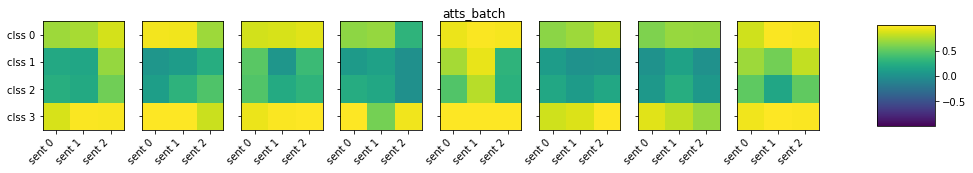

entity                                             logits             p  \
0    foo    [-4.3156786, -5.472097, -2.5643802, -5.4306154]  [0, 0, 0, 0]   
1    foo  [-1.7739944, -1.5937253, 0.062165737, -2.9191287]  [0, 0, 1, 0]   
2    foo      [1.8668675, 0.016140155, 0.679254, -3.580904]  [1, 1, 1, 0]   
3    foo     [1.8223324, 0.06574543, 0.88936925, 0.9087764]  [1, 1, 1, 1]   
4    foo     [-3.5385902, -4.1723166, -3.1789534, -4.85705]  [0, 0, 0, 0]   
5    foo    [-2.6790438, -4.035304, -2.1940644, -3.1077142]  [0, 0, 0, 0]   
6    foo   [-1.3379179, -3.6041818, -1.9372609, -2.4472492]  [0, 0, 0, 0]   
7    foo        [1.9049561, 0.119844, 1.1667403, 3.3845844]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, rando

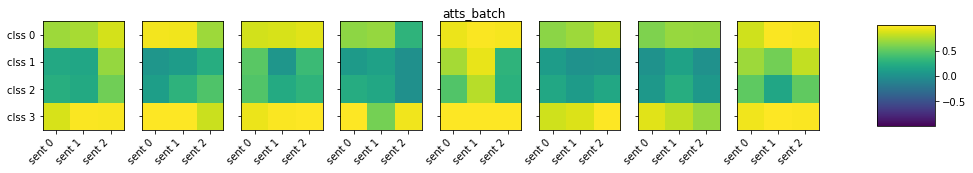

Epoch 5


entity                                               logits             p  \
0    foo    [-1.7410551, -2.5988169, -1.7390687, -0.26894855]  [0, 0, 0, 0]   
1    foo     [-6.2865458, -14.345022, -24.611631, -11.091734]  [0, 0, 0, 0]   
2    foo  [-0.44608343, -1.0012633, -0.038151026, -2.2400126]  [0, 0, 0, 0]   
3    foo      [-4.6460056, -3.5652719, -3.967633, -3.2796338]  [0, 0, 0, 0]   
4    foo       [-4.2993755, -5.9771495, -6.098674, -6.215965]  [0, 0, 0, 0]   
5    foo         [1.15398, 0.23948824, 1.0798321, 0.46092594]  [1, 1, 1, 1]   
6    foo      [-0.26391554, -1.0061522, -1.1385412, -1.41191]  [0, 0, 0, 0]   
7    foo        [-4.606174, -4.5235944, -5.147958, -6.364558]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [1, 0, 1, 0]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 sents  
0                                                                     [[jayne, mansfield, was, born, vera, jayne, palmer, on, april, 19,, 1933,, in, bryn, mawr,, pennsylvania., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [several, scenes, were, filmed, in, the, historic, bryn, mawr, college, in, bryn, mawr,, pennsylvania, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [andrea, gilbert, currently, serves, as, the, president, of, bryn, mawr, hospital., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                          [[notable, academy, graduates, in, recent, years, include, 2002, fifa, world, cup, winner, and, two-time, fifa, ballon, d'or, recipient, ronaldinho,, brazil, national, team, and, juventus, winger, douglas, cos

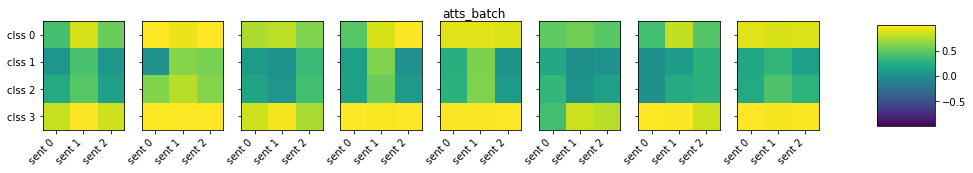

entity                                            logits             p  \
0    foo    [-4.630255, -5.2504563, -2.7735763, -5.280568]  [0, 0, 0, 0]   
1    foo  [-2.4113483, -1.3112991, 0.16732597, -2.9463139]  [0, 0, 1, 0]   
2    foo      [1.370248, 0.22806719, 0.815652, -3.5025823]  [1, 1, 1, 0]   
3    foo      [1.6373221, 0.3006817, 0.9640498, 0.7272319]  [1, 1, 1, 1]   
4    foo      [-3.9258518, -4.402851, -3.56776, -5.096261]  [0, 0, 0, 0]   
5    foo  [-2.9512613, -4.2428093, -2.4266837, -3.2218502]  [0, 0, 0, 0]   
6    foo  [-1.5267473, -3.1351824, -2.1380458, -2.5838106]  [0, 0, 0, 0]   
7    foo     [1.7846733, 0.36348984, 1.3223765, 3.1044772]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

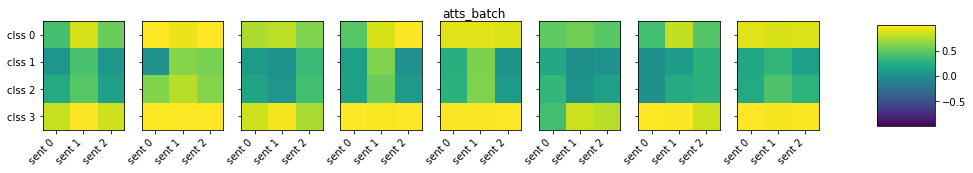

Epoch 6


entity                                            logits             p  \
0    foo  [0.9225732, -0.4213248, 0.41612613, -0.85022587]  [1, 0, 1, 0]   
1    foo    [-6.1718564, -10.055559, -3.278119, -4.735047]  [0, 0, 0, 0]   
2    foo     [-3.744955, -3.9964566, -7.143138, -6.658262]  [0, 0, 0, 0]   
3    foo    [0.17043042, 0.20555902, 0.6889128, 2.3132622]  [1, 1, 1, 1]   
4    foo      [-3.625711, -3.850511, -3.55682, -1.8915771]  [0, 0, 0, 0]   
5    foo     [1.2424289, 0.14469655, 0.73485506, 1.618865]  [1, 1, 1, 1]   
6    foo    [-2.1198783, -3.647242, -7.1072655, -5.835117]  [0, 0, 0, 0]   
7    foo    [1.6294156, 0.20716985, 0.94282234, 1.6146798]  [1, 1, 1, 1]   

             gt  \
0  [1, 1, 1, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 1, 1, 1]   
4  [0, 0, 0, 0]   
5  [1, 1, 0, 1]   
6  [0, 0, 0, 0]   
7  [1, 1, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     sents  
0                                                     [[with, the, other, thunder, players, struggling, to, make, their, shots,, miami, was, able, to, pull, away, in, the, end,, largely, thanks, to, late-game, heroics, from, lebron, james,, mario, chalmers, and, dwyane, wade., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [dwyane, wade, scores, 40, as, the, defending, nba, champions, breeze, to, victory., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [all-stars, lebron, james,, dwyane, wade,, and, chris, bosh, and, the, miami, heat., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                                                                      [[stowe, was, born, in, amherst,, ohio,, on, april, 15,, 1966, to, john, and, lucy, stowe, and, grew, up, in, lorain,, ohio., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <

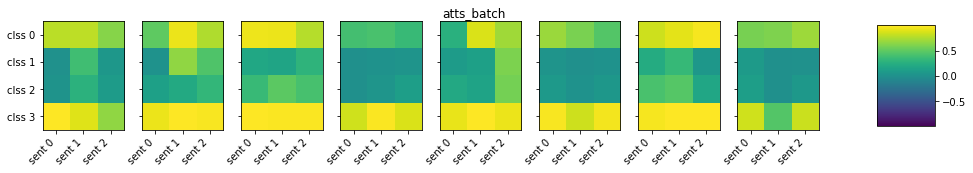

entity                                           logits             p  \
0    foo  [-4.213671, -4.4615226, -2.5641787, -5.2331967]  [0, 0, 0, 0]   
1    foo  [-2.1135733, -0.6974277, 0.2656603, -3.1357944]  [0, 0, 1, 0]   
2    foo    [1.774023, 0.39156693, 0.9551244, -3.5324047]  [1, 1, 1, 0]   
3    foo    [2.0563014, 0.46043935, 1.0161773, 0.4647364]  [1, 1, 1, 1]   
4    foo   [-3.653911, -4.294671, -3.3997724, -5.1717763]  [0, 0, 0, 0]   
5    foo  [-2.8809366, -3.8777523, -2.493982, -3.3720272]  [0, 0, 0, 0]   
6    foo   [-1.2908114, -2.70572, -2.0496747, -2.6749978]  [0, 0, 0, 0]   
7    foo       [2.408935, 0.533006, 1.4436765, 2.9568105]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and, rachael

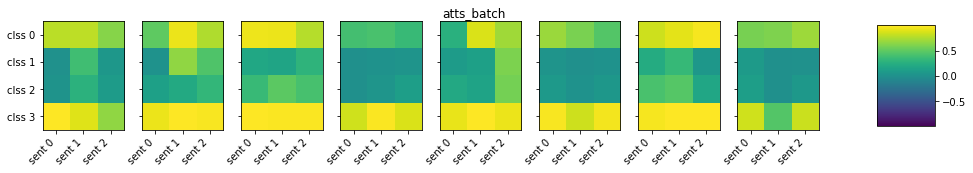

Epoch 7


entity                                              logits             p  \
0    foo     [-2.5212598, -4.201713, -3.9007041, -2.2566857]  [0, 0, 0, 0]   
1    foo       [-3.646038, -6.072881, -11.076799, -8.120348]  [0, 0, 0, 0]   
2    foo    [-2.4525583, -3.9613423, -3.7225564, -4.2990522]  [0, 0, 0, 0]   
3    foo  [-2.2900655, -0.78680795, -1.5557938, -0.21500254]  [0, 0, 0, 0]   
4    foo    [-2.1871498, -2.7801354, -2.0142438, -1.4696568]  [0, 0, 0, 0]   
5    foo    [-1.8274103, -3.1568027, -2.2925217, -2.6043105]  [0, 0, 0, 0]   
6    foo     [-2.0103061, -3.5573611, -4.7330217, -1.754681]  [0, 0, 0, 0]   
7    foo    [-1.9452376, -3.4375448, -2.4825613, -3.8811576]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  sents  
0              [[alternative, hip, hop, is,, most, likely,, bigger, than, gangsta, and, hardcore, combined., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [he’s, one, of, the, first, artists, to, be, unabashed, about, his, depressive, ruminations, and, did, so, in, a, melodically, intriguing, manner, that, progressed, alternative, rock, aesthetics, into, the, hip-hop, world, one, cadence, at, a, time., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [baby, d,, also, now, known, as, dizzle,, (born, as, donald, b., jenkins, on, november, 5,, 1984), is, an, underground, rapper, from, atlanta., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1        [[he, was, a, professor, at, the, university, of, belgrade, faculty, of, law, (1920-1936),, first, dean, of, the, sarajevo, law, school, (1947-1949), and, professor, of, slavic, studies, at, the, university, of, geneva, (1951-1961)., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk

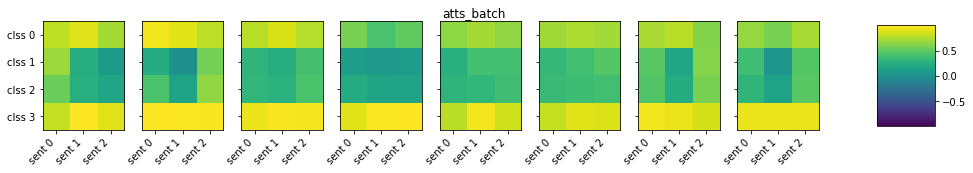

entity                                            logits             p  \
0    foo  [-3.9321942, -3.5581996, -2.3479543, -5.0541687]  [0, 0, 0, 0]   
1    foo   [-2.181439, -0.18856639, 0.4383812, -3.0757282]  [0, 0, 1, 0]   
2    foo    [1.6220764, 0.52783877, 1.0619969, -3.2879417]  [1, 1, 1, 0]   
3    foo    [2.0489535, 0.56437385, 1.0389707, 0.39312264]  [1, 1, 1, 1]   
4    foo    [-3.3932502, -4.106312, -3.3180914, -5.129678]  [0, 0, 0, 0]   
5    foo      [-2.8736253, -3.410895, -2.50569, -3.398076]  [0, 0, 0, 0]   
6    foo  [-1.1451689, -2.3810594, -2.0024922, -2.6956851]  [0, 0, 0, 0]   
7    foo      [2.7893085, 0.6502571, 1.5188599, 3.0088124]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

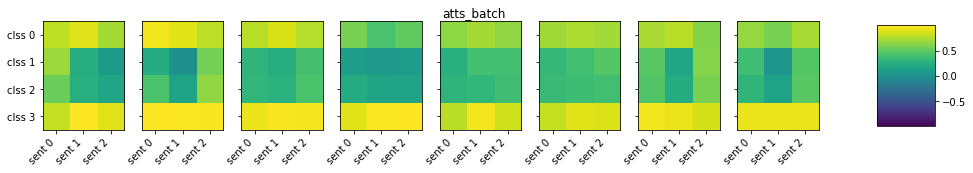

Epoch 8


entity                                            logits             p  \
0    foo     [3.3265572, 0.5116912, 0.73349094, 0.7737762]  [1, 1, 1, 1]   
1    foo  [-7.1432967, -10.658567, -16.836039, -7.8835573]  [0, 0, 0, 0]   
2    foo    [-5.514994, -3.4626315, -2.8750849, -6.190412]  [0, 0, 0, 0]   
3    foo    [-2.902691, -4.078435, -3.5768728, -2.8895981]  [0, 0, 0, 0]   
4    foo    [-4.508664, -6.8169346, -8.433037, -5.9035587]  [0, 0, 0, 0]   
5    foo   [-3.2191024, -2.2653353, -3.084414, -5.0654135]  [0, 0, 0, 0]   
6    foo    [-3.1408954, -5.471054, -5.1553617, -3.778053]  [0, 0, 0, 0]   
7    foo  [0.009924412, -2.614771, -1.5379767, -3.6657388]  [1, 0, 0, 0]   

             gt  \
0  [1, 1, 1, 1]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                sents  
0                                                 [[he, outplayed, centers, such, as, patrick, ewing,, david, robinson,, shaquille, o'neal,, and, dikembe, mutombo,, and, other, defensive, stalwarts, such, as, dennis, rodman, and, karl, malone., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [it, includes, allusions, to, the, undertones,, jackson, browne,, dennis, rodman, and, jackie, chan,, and, cribbed, the, work, of, good, charlotte., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [he, also, appeared, in, the, us, movie, simon, sez, with, dennis, rodman, in, 1999., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                               [[as, an, undergraduate,, he, held, a, scholarship,, played, soccer, for, cambridge, university, and, hockey, for, cambridgeshire,, was, in, his, college's, cricket, first, xi, and, crowned, his, first, four, years, with, a, double, first, in, the, natural, science

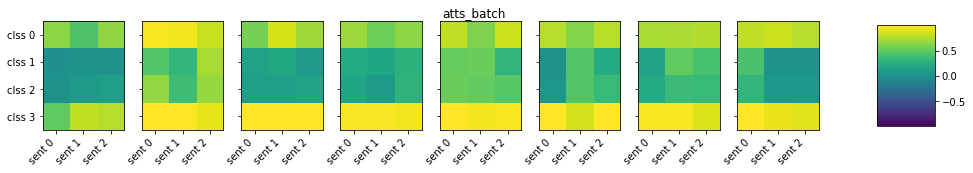

entity                                              logits             p  \
0    foo       [-4.328806, -4.885189, -3.5943654, -4.982089]  [0, 0, 0, 0]   
1    foo  [-2.6188452, -0.65254307, 0.055663586, -3.2528734]  [0, 0, 1, 0]   
2    foo       [1.4319067, 0.5486097, 1.0012969, -2.9394732]  [1, 1, 1, 0]   
3    foo       [2.1949568, 0.60338134, 1.0091732, 0.1837793]  [1, 1, 1, 1]   
4    foo      [-3.6845567, -4.9523163, -4.125537, -5.175497]  [0, 0, 0, 0]   
5    foo     [-3.1907077, -4.2433615, -3.068639, -3.4213214]  [0, 0, 0, 0]   
6    foo     [-1.2602835, -2.6217802, -2.2902024, -2.769718]  [0, 0, 0, 0]   
7    foo        [2.8220007, 0.7228509, 1.5720587, 3.0007713]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robe

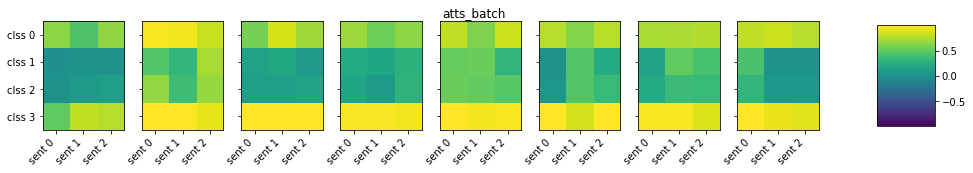

Epoch 9


entity                                            logits             p  \
0    foo   [-3.5791376, -6.124258, -6.9757442, -3.7337239]  [0, 0, 0, 0]   
1    foo     [-3.5693045, -7.680949, -11.34968, -4.166437]  [0, 0, 0, 0]   
2    foo  [-3.2475314, -2.8506126, -6.4338293, -5.8410053]  [0, 0, 0, 0]   
3    foo   [0.2295177, -2.9759908, -2.6166599, -2.1677747]  [1, 0, 0, 0]   
4    foo        [-1.2079303, 0.707426, 1.532785, 3.773567]  [0, 1, 1, 1]   
5    foo   [-4.7156696, -4.2280073, -4.8769026, -3.936764]  [0, 0, 0, 0]   
6    foo  [-0.16866231, 0.18029141, 0.47053266, 1.0963761]  [0, 1, 1, 1]   
7    foo    [-3.0058377, -3.9035895, -8.183166, -4.346245]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [0, 1, 0, 1]   
5  [0, 0, 0, 0]   
6  [1, 1, 0, 1]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             sents  
0                            [[he, attended, peterhouse,, cambridge,, where, he, studied, history., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [educated, at, charterhouse, until, 1752,, he, then, went, to, peterhouse,, cambridge, and, in, 1754, began, legal, studies, at, the, inner, temple,, being, called, to, the, bar, on, 24, november, 1758., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [he, was, educated, at, dauntsey's, school, and, peterhouse,, cambridge,, where, he, took, a, scholarship, and, became, a, prizeman, in, natural, sciences., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                                   [[it, ran, between, the, city, of, sapporo, on, the, northern, island, of, hokkaido, and, osaka, in, south-western, honshu,, a, distance, of, approximately, ,, with, the, journey, taking, between, 22, and, 23, hours., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <u

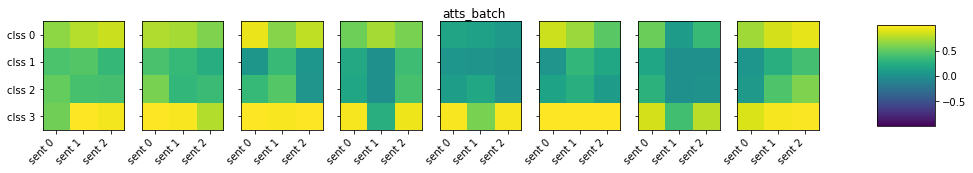

entity                                            logits             p  \
0    foo   [-4.2864366, -5.248323, -2.3659062, -4.8357987]  [0, 0, 0, 0]   
1    foo   [-2.7145205, -0.7177304, 0.6887864, -3.1869943]  [0, 0, 1, 0]   
2    foo    [1.4434406, 0.58345634, 1.2696495, -2.7346983]  [1, 1, 1, 0]   
3    foo     [2.3733282, 0.635437, 1.1425924, 0.101926446]  [1, 1, 1, 1]   
4    foo   [-3.6540608, -5.1432986, -3.207026, -5.1120048]  [0, 0, 0, 0]   
5    foo  [-3.2691545, -4.2512803, -2.5142565, -3.4296854]  [0, 0, 0, 0]   
6    foo  [-1.2776542, -2.5691323, -1.8401694, -2.7835846]  [0, 0, 0, 0]   
7    foo      [2.9562097, 0.7691853, 1.6782188, 3.1394143]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

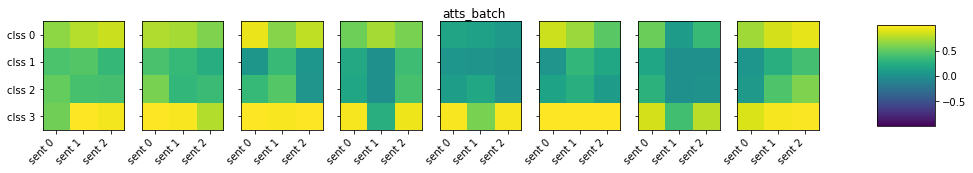

Epoch 10


entity                                              logits             p  \
0    foo        [2.689249, 0.15264612, 0.8978311, -0.789939]  [1, 1, 1, 0]   
1    foo      [-1.682919, -1.2428713, -1.42412, -0.82111126]  [0, 0, 0, 0]   
2    foo  [0.85034597, -0.10299146, 0.098653436, -0.5833493]  [1, 0, 1, 0]   
3    foo    [-2.5560596, -1.5786438, -2.1752427, -2.3691885]  [0, 0, 0, 0]   
4    foo       [-6.112113, -9.577934, -6.158988, -6.5458727]  [0, 0, 0, 0]   
5    foo    [-1.4330391, -0.8438394, -1.1762867, -1.1334987]  [0, 0, 0, 0]   
6    foo     [0.7533115, 0.2453286, 0.21329033, -0.71915513]  [1, 1, 1, 0]   
7    foo    [-1.6908053, -3.5641894, -2.1964345, -3.2047806]  [0, 0, 0, 0]   

             gt  \
0  [1, 1, 1, 1]   
1  [0, 0, 0, 0]   
2  [0, 1, 1, 1]   
3  [0, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [1, 1, 0, 1]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    sents  
0  [[trevorrow, wrote, the, screenplay, with, connolly,, while, trevorrow,, frank, marshall,, big, beach,, and, spielberg's, amblin, entertainment, were, announced, as, producing, the, film., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [in, 1992,, kathleen, kennedy, and, frank, marshall, left, amblin, entertainment, to, form, their, own, self-titled, banner, the, kennedy/marshall, company, with, a, 3-year, first, look, deal, at, paramount, pictures., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [filmed, on, location, in, the, purcell, mountains, in, british, columbia,, the, film, was, directed, by, frank, marshall,, written, by, john, patrick, shanley,, and, narrated, by, john, malkovich., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                               [[aranha, has, since, had, roles, in, are, you, afraid, of, the, dark?,, new, york, undercover,, and, law, &, order,, and, has, roles, in, dead, man, walking, (1995),, deconstructing, harry, (1997),, and, maid, in, manhattan, (2002)., <unk>, <unk>, <unk>,

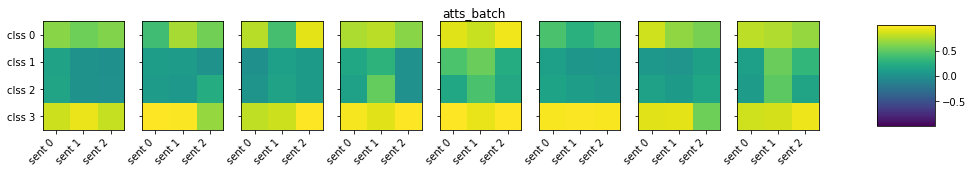

entity                                              logits             p  \
0    foo     [-4.7092953, -4.9026523, -4.691037, -4.6747847]  [0, 0, 0, 0]   
1    foo  [-3.2724285, -0.6321935, -0.042649984, -3.1700337]  [0, 0, 0, 0]   
2    foo     [0.61645555, 0.63286287, 1.0094023, -2.4756534]  [1, 1, 1, 0]   
3    foo     [1.6293004, 0.66382873, 1.0197092, -0.13184166]  [1, 1, 1, 0]   
4    foo      [-3.8718915, -4.974218, -4.7701244, -5.088652]  [0, 0, 0, 0]   
5    foo    [-3.5296302, -4.1109796, -3.4578605, -3.3563673]  [0, 0, 0, 0]   
6    foo      [-1.4991388, -2.35659, -2.3956122, -2.7921352]  [0, 0, 0, 0]   
7    foo          [2.223743, 0.8147881, 1.6355114, 3.188285]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robe

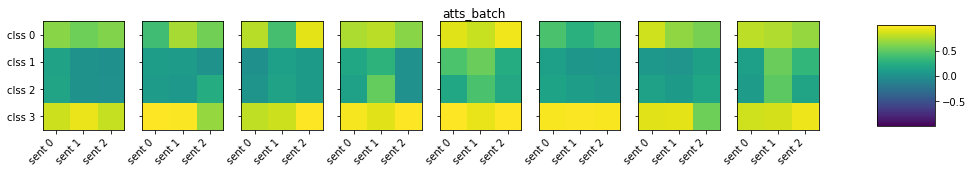

Epoch 11


entity                                                 logits             p  \
0    foo        [-2.101429, -4.5927014, -7.4233513, -3.7721922]  [0, 0, 0, 0]   
1    foo         [-6.9699073, -6.522526, -6.7024746, -6.094913]  [0, 0, 0, 0]   
2    foo  [-1.239871, -0.116170645, -0.10754192, -0.0153182745]  [0, 0, 0, 0]   
3    foo      [-0.38096547, 0.53121966, 0.30326295, 0.42938358]  [0, 1, 1, 1]   
4    foo           [-1.4471868, -0.8804, -1.8562692, -2.224048]  [0, 0, 0, 0]   
5    foo      [-1.0328844, 0.17104453, -0.0016161203, 5.585143]  [0, 1, 0, 1]   
6    foo        [-3.3660145, -4.4005404, -4.1977806, -2.652233]  [0, 0, 0, 0]   
7    foo         [-5.7730155, -9.480307, -9.501368, -5.4826236]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [1, 1, 1, 1]   
5  [1, 1, 1, 1]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 sents  
0                                     [[gestalt, therapy,, an, approach, created, by, fritz, perls,, was, based, on, phenomenology,, existentialism, and, also, zen, buddhism, and, taoism., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, sri, vijayan, empire, had, adopted, mahayana, and, vajrayana, buddhism,, under, a, line, of, rulers, named, the, sailendra., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [as, with, many, buddhist, scholars, of, the, day,, doctrinal, classification, (p’an, chiao), was, an, integral, part, of, zongmi's, work., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                                        [[san, francisco, mayor, gavin, newsom, made, a, friendly, wager, with, arlington, mayor, robert, cluck,, agreeing, that, "the, losing, city's, mayor, will, travel, to, the, winning, city, and,

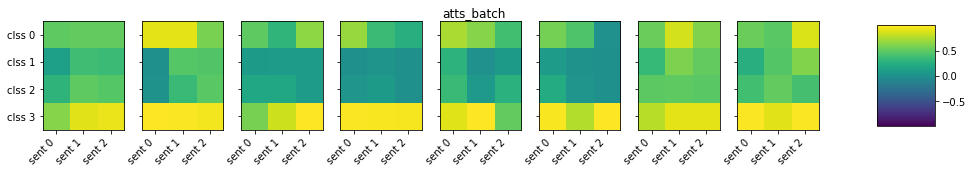

entity                                            logits             p  \
0    foo     [-4.240714, -5.429676, -3.0008636, -4.536628]  [0, 0, 0, 0]   
1    foo  [-2.7826216, -1.0287237, 0.45431995, -3.0059633]  [0, 0, 1, 0]   
2    foo     [1.4673204, 0.62762773, 1.217168, -2.2111316]  [1, 1, 1, 0]   
3    foo    [2.3958197, 0.6594334, 1.0657269, -0.17941082]  [1, 1, 1, 0]   
4    foo   [-3.5334272, -5.0792994, -3.4384265, -4.967362]  [0, 0, 0, 0]   
5    foo     [-3.3698647, -4.250959, -3.036806, -3.304877]  [0, 0, 0, 0]   
6    foo    [-1.205999, -2.3359478, -1.893814, -2.8055954]  [0, 0, 0, 0]   
7    foo      [3.282002, 0.84930885, 1.7020978, 3.4022872]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

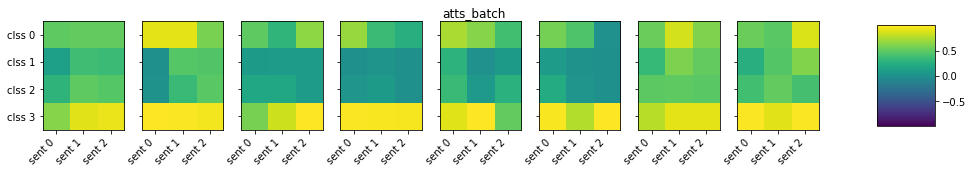

Epoch 12


entity                                            logits             p  \
0    foo   [-1.8130193, -2.2299905, -2.0505953, -3.272162]  [0, 0, 0, 0]   
1    foo     [-6.739, -11.073058, -14.7399435, -5.7357635]  [0, 0, 0, 0]   
2    foo  [-2.1382458, -3.3856514, -3.3048563, -3.5981307]  [0, 0, 0, 0]   
3    foo   [-3.0631382, -4.4654818, -4.202113, -1.0813422]  [0, 0, 0, 0]   
4    foo    [-4.4064302, -6.3758297, -5.887702, -3.295966]  [0, 0, 0, 0]   
5    foo  [-13.094894, -31.848343, -34.689404, -13.146746]  [0, 0, 0, 0]   
6    foo    [-0.5079837, -2.5328825, -4.954002, -3.573265]  [0, 0, 0, 0]   
7    foo    [-5.918143, -6.8479443, -6.5420713, -7.248435]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   sents  
0                                                                                                  [[jean-jacques, annaud, (born, 1, october, 1943), is, a, french, film, director,, screenwriter, and, producer,, best, known, for, directing, quest, for, fire, (1981),, the, name, of, the, rose, (1986),, the, bear, (1988),, the, lover, (1992),, seven, years, in, tibet, (1997),, enemy, at, the, gates, (2001),, black, gold, (2011),, and, wolf, totem, (2015)., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [his, career, improved, with, his, role, in, the, name, of, the, rose, (1986), alongside, sean, connery., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [bambi, award, for, best, film, for, the, name, of, the, rose, (germany)., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                                                      [[situated, on, the, banks, of, gomti,, the, lucknow, campus, is, housed, in, the, moti, mahal, campus,, ranapratap, marg,, lucknow., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>

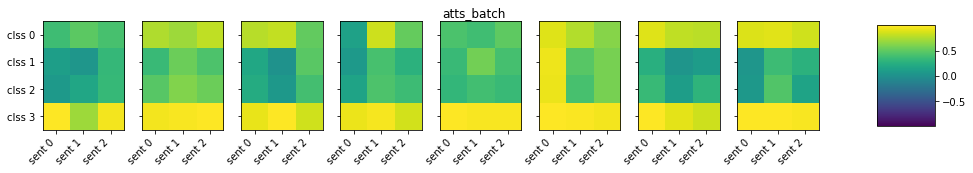

entity                                            logits             p  \
0    foo  [-5.2236986, -4.8233247, -3.4289467, -4.5037384]  [0, 0, 0, 0]   
1    foo   [-3.6200752, -0.6605492, 0.37726736, -3.057526]  [0, 0, 1, 0]   
2    foo      [0.9127331, 0.7255832, 1.217665, -2.2542627]  [1, 1, 1, 0]   
3    foo   [2.4116807, 0.72138995, 1.0809331, -0.33561528]  [1, 1, 1, 0]   
4    foo   [-4.1059933, -4.9431334, -3.7971284, -5.012143]  [0, 0, 0, 0]   
5    foo    [-3.8815236, -3.754833, -3.210613, -3.3123755]  [0, 0, 0, 0]   
6    foo   [-1.628205, -2.2428756, -2.0052664, -2.8837824]  [0, 0, 0, 0]   
7    foo       [2.722485, 0.9015297, 1.7309052, 3.3559265]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

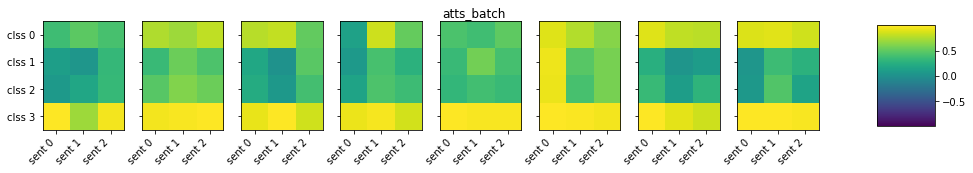

Epoch 13


entity                                              logits             p  \
0    foo     [0.427258, -0.35710222, -1.2798746, -2.1711774]  [1, 0, 0, 0]   
1    foo      [-4.5453773, -6.493636, -5.743352, -5.2596107]  [0, 0, 0, 0]   
2    foo      [-5.1809754, -5.688055, -8.109034, -4.4330964]  [0, 0, 0, 0]   
3    foo      [1.1137843, 0.09130043, 0.1151948, -2.0892985]  [1, 1, 1, 0]   
4    foo         [-5.638153, -9.56908, -8.190627, -6.143233]  [0, 0, 0, 0]   
5    foo    [-1.2875258, 0.24420208, 0.30936408, -1.5501926]  [0, 1, 1, 0]   
6    foo    [-3.3756247, -5.5524206, -6.0042534, -4.1396294]  [0, 0, 0, 0]   
7    foo  [-0.90899163, -0.79625815, -0.7204397, -3.0130384]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [1, 1, 1, 0]   
4  [0, 0, 0, 0]   
5  [1, 1, 1, 1]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0  [[the, song, has, been, used, as, part, of, the, soundtrack, of, il, divo,, an, italian, movie, by, director, paolo, sorrentino., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, has, been, used, in, the, italian, film, il, divo,, directed, by, paolo, sorrentino,, a, fictional, biography, of, italian, politician, giulio, andreotti., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [sorrentino's, following, film,, il, divo,, is, a, dramatised, biopic, of, giulio, andreotti,, the, controversial, italian, politician., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                             [[the, film, was, nominated, for, a, golden, raspberry, award, for, worst, original, song, for, the, song, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk

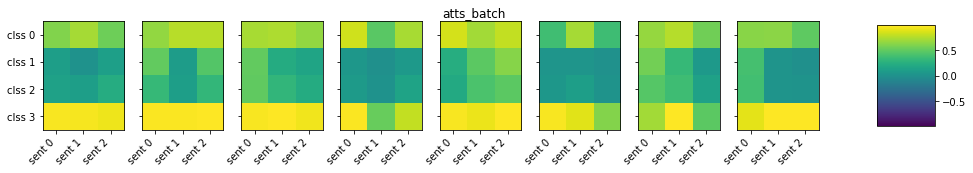

entity                                            logits             p  \
0    foo  [-4.3890667, -5.2744436, -3.8353767, -4.3733416]  [0, 0, 0, 0]   
1    foo   [-3.1106029, -0.986402, 0.31149113, -2.8602295]  [0, 0, 1, 0]   
2    foo    [1.0240974, 0.70454574, 1.2029023, -1.7995214]  [1, 1, 1, 0]   
3    foo   [2.3880222, 0.71842015, 1.0749173, -0.34244686]  [1, 1, 1, 0]   
4    foo   [-3.5562744, -5.1865773, -4.0546618, -4.933784]  [0, 0, 0, 0]   
5    foo    [-3.581647, -3.9486237, -3.3869638, -3.263044]  [0, 0, 0, 0]   
6    foo  [-1.3315314, -2.2179651, -2.0828896, -2.8759387]  [0, 0, 0, 0]   
7    foo      [3.1435773, 0.9208029, 1.7570915, 3.6070008]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

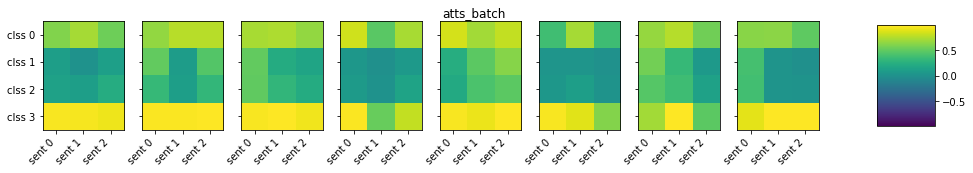

Epoch 14


entity                                              logits             p  \
0    foo  [-1.1384399, -0.19643813, -0.5366298, 0.033011198]  [0, 0, 0, 1]   
1    foo       [-2.726565, -2.5491862, -5.759542, -5.698673]  [0, 0, 0, 0]   
2    foo         [-4.904997, -7.361046, -9.25698, -5.785549]  [0, 0, 0, 0]   
3    foo     [-3.8953924, -6.6339283, -6.320587, -3.2781806]  [0, 0, 0, 0]   
4    foo     [1.2573822, 0.72874784, 1.0158898, 0.117173314]  [1, 1, 1, 1]   
5    foo      [0.6603086, 0.5222188, 0.43699193, -2.8287377]  [1, 1, 1, 0]   
6    foo      [-11.68191, -31.767529, -20.04251, -13.093302]  [0, 0, 0, 0]   
7    foo      [-9.101514, -21.893612, -16.418468, -9.484491]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [1, 1, 1, 0]   
5  [1, 1, 1, 0]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                sents  
0                                                                [[the, following, year,, he, played, opposite, sandra, bullock, in, the, romantic, comedy, miss, congeniality, and, had, a, small, role, as, part, of, a, stellar, ensemble, cast, of, traffic,, which, also, included, benicio, del, toro,, michael, douglas,, don, cheadle, and, catherine, zeta-jones., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [as, traffic, was, wrapping, up,, soderbergh, began, drafting, a, script., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [during, the, release, of, traffic,, a, critic, commented, on, one, of, the, teen, characters, in, the, movie, who, is, a, drug, addict, and, a, straight-a, student,, calling, it, unrealistic,, which, gaghan, defended, by, stating, that, he, had, straight, a's, while, he, was, addicted, to, drugs, and, alcohol., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                              [[the, parish, church, (now, redundant), was, used, for, the, funeral, in, the, film, four, weddings, and, a, funeral., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <u

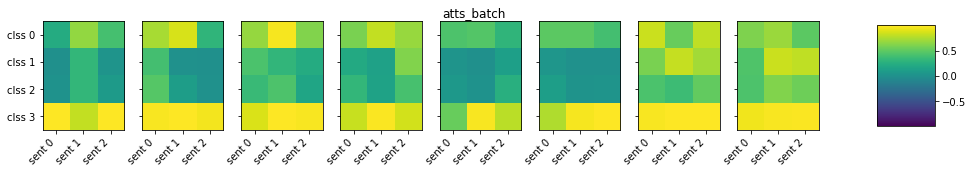

entity                                            logits             p  \
0    foo   [-4.6513505, -5.061185, -4.2138815, -4.4576464]  [0, 0, 0, 0]   
1    foo  [-3.4531763, -0.9543856, 0.22061574, -2.8284078]  [0, 0, 1, 0]   
2    foo    [0.2992469, 0.72187936, 1.1455591, -1.8017807]  [1, 1, 1, 0]   
3    foo    [1.5755726, 0.7363813, 1.0350523, -0.31873655]  [1, 1, 1, 0]   
4    foo     [-3.6090827, -5.000114, -4.264384, -5.103778]  [0, 0, 0, 0]   
5    foo  [-3.7662578, -3.6849258, -3.5437717, -3.3358555]  [0, 0, 0, 0]   
6    foo   [-1.5100332, -2.1309707, -2.1673288, -2.983759]  [0, 0, 0, 0]   
7    foo      [2.1786199, 0.9441987, 1.7660228, 3.5249202]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

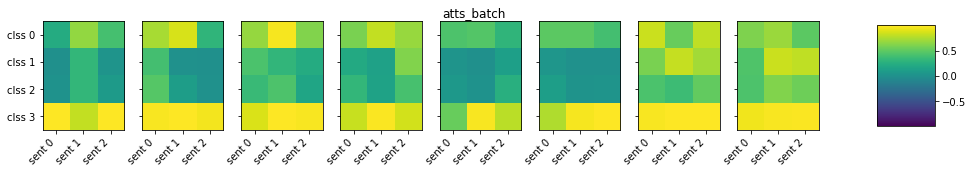

Epoch 15


entity                                           logits             p  \
0    foo   [4.048201, 0.43781906, 0.6554749, -0.90771013]  [1, 1, 1, 0]   
1    foo   [-6.499152, -11.535145, -14.256818, -8.803006]  [0, 0, 0, 0]   
2    foo  [-2.6797967, -3.9844997, -4.354703, -4.0468035]  [0, 0, 0, 0]   
3    foo    [1.0900227, 0.7360339, 1.3444662, -2.2506824]  [1, 1, 1, 0]   
4    foo  [-2.3795688, -4.3850117, -7.731742, -4.2091694]  [0, 0, 0, 0]   
5    foo  [-0.6306914, 0.47544807, 0.75060153, 2.6911414]  [0, 1, 1, 1]   
6    foo  [-1.094368, -0.62017184, -0.959211, -1.2433383]  [0, 0, 0, 0]   
7    foo   [-4.609114, -7.0787535, -2.9901042, -5.500289]  [0, 0, 0, 0]   

             gt  \
0  [1, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [1, 1, 1, 0]   
4  [1, 1, 0, 0]   
5  [1, 0, 1, 1]   
6  [1, 0, 1, 1]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  sents  
0              [[the, original, music, score, is, composed, by, john, williams, and, the, cinematography, is, by, donald, mcalpine., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [his, interviewees, included, andrew, adamson,, pete, docter,, bill, george,, donald, mcalpine,, barrie, m., osborne,, tim, johnson,, chris, wedge, and, dean, wright., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [cinematographer, don, mcalpine, was, born, and, raised, in, quandialla., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                                                                [[it, won, the, academy, award, for, animated, short, film, at, the, 48th, academy, awards, in, march, 1976., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <un

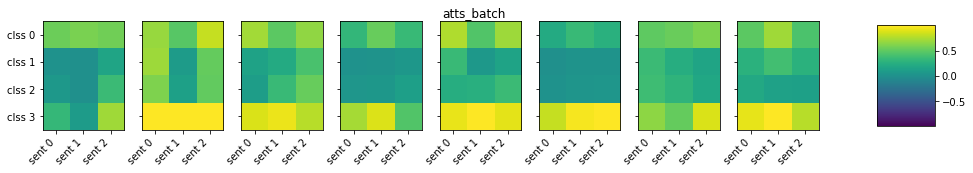

entity                                            logits             p  \
0    foo    [-4.8523035, -4.713682, -3.7935889, -4.185455]  [0, 0, 0, 0]   
1    foo   [-3.3017962, -1.0027815, 0.3925941, -2.6839876]  [0, 0, 1, 0]   
2    foo     [1.6884123, 0.7553828, 1.2333497, -1.6308845]  [1, 1, 1, 0]   
3    foo    [3.549684, 0.73405683, 1.0966009, -0.46549577]  [1, 1, 1, 0]   
4    foo    [-3.8504853, -4.8799067, -3.975569, -4.821391]  [0, 0, 0, 0]   
5    foo  [-3.9371023, -3.6965058, -3.5212715, -3.1858697]  [0, 0, 0, 0]   
6    foo    [-1.4363394, -2.0384467, -2.009897, -2.894493]  [0, 0, 0, 0]   
7    foo     [3.7561383, 0.96651965, 1.8125486, 3.7642398]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

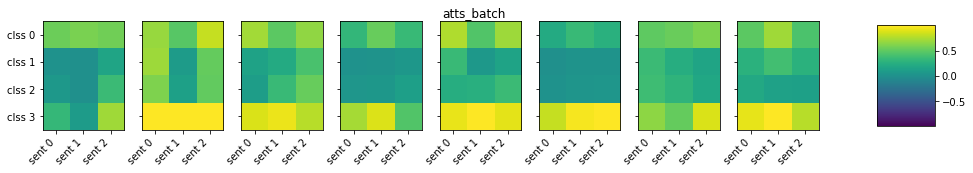

Epoch 16


entity                                            logits             p  \
0    foo     [-3.03371, -3.4971263, -1.0320764, -3.811407]  [0, 0, 0, 0]   
1    foo    [-3.2724447, -2.807861, -3.132993, -5.0894246]  [0, 0, 0, 0]   
2    foo    [-5.2184286, -4.367854, -3.2805116, -5.987806]  [0, 0, 0, 0]   
3    foo    [-3.31459, 0.22451317, 0.74944305, -1.6461066]  [0, 1, 1, 0]   
4    foo  [-2.6577923, -2.4732568, -2.8307478, -1.0458732]  [0, 0, 0, 0]   
5    foo      [0.7275473, 0.5365897, 0.7485292, 1.7735037]  [1, 1, 1, 1]   
6    foo  [-1.3344488, -2.4748633, -2.8935082, -1.2199156]  [0, 0, 0, 0]   
7    foo    [-7.8341947, -12.419582, -19.23947, -8.124465]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [1, 1, 0, 1]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               sents  
0                                                                                   [[in, his, introduction, to, the, 2006, edition, of, lady, sings, the, blues,, music, biographer, david, ritz, writes:, "(holiday's), voice,, no, matter, how, the, dufty/holiday, interviewing, process, went,, is, as, real, as, rain.", <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [this, is, the, second, of, three, jazz, albums, that, diana's, recorded, including, "lady, sings, the, blues", and, "blue"., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, recipient, of, an, academy, award, nomination, for, co-writing, the, screenplay, lady, sings, the, blues, making, her, the, first, person, of, color, to, be, nominated, for, best, original, screenplay,, as, well, as, the, first, black, woman, nominated, in, any, category, besides, an, acting, category., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                                                                           [[collins', most, ruthless, officers, and, men, were, recruited, from, the, dublin, active, service, unit, (the, elite, unit, of, the, ira's, d

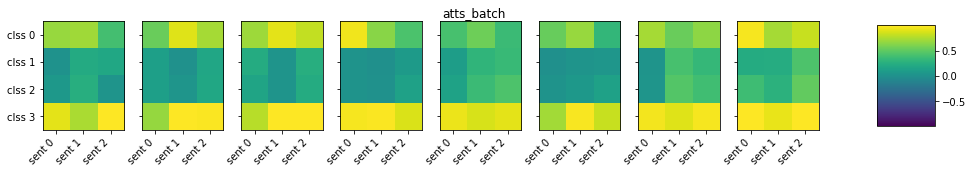

entity                                             logits             p  \
0    foo   [-4.9485435, -5.6500106, -4.3134995, -4.4826627]  [0, 0, 0, 0]   
1    foo  [-3.7289376, -1.3359294, 0.044790864, -2.9474733]  [0, 0, 1, 0]   
2    foo     [0.07541466, 0.7216372, 1.1937846, -1.9694854]  [1, 1, 1, 0]   
3    foo     [1.7042102, 0.73767257, 1.0578727, -0.6203057]  [1, 1, 1, 0]   
4    foo     [-3.775507, -5.7001696, -4.168828, -5.1175623]  [0, 0, 0, 0]   
5    foo     [-4.063158, -3.8206167, -3.810358, -3.3697808]  [0, 0, 0, 0]   
6    foo   [-1.6229885, -2.2875402, -2.0910134, -3.0578225]  [0, 0, 0, 0]   
7    foo        [2.0854506, 0.9846613, 1.8482128, 3.387321]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, rando

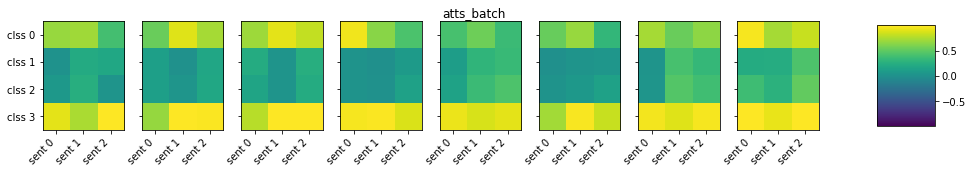

Epoch 17


entity                                               logits             p  \
0    foo     [-7.6054463, -16.168034, -18.401398, -10.411762]  [0, 0, 0, 0]   
1    foo      [-1.7516582, -1.9987009, -2.839491, -3.1784282]  [0, 0, 0, 0]   
2    foo       [-3.4765735, -7.628487, -6.202709, -4.4994245]  [0, 0, 0, 0]   
3    foo      [-2.4351761, -2.1972883, -2.4520068, -3.376302]  [0, 0, 0, 0]   
4    foo    [-6.0566072, -10.2143345, -12.197609, -5.6526957]  [0, 0, 0, 0]   
5    foo  [0.61134064, -0.24860382, -0.42655504, -0.37234986]  [1, 0, 0, 0]   
6    foo       [-7.105572, -13.307566, -20.75614, -7.3672385]  [0, 0, 0, 0]   
7    foo        [-4.1104064, -6.07114, -8.215943, -4.1958356]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [1, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        sents  
0                                   [[she, received, an, md, in, 1995, and, was, appointed, dean, of, the, university, college, cork, school, of, medicine, in, 2014., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [list, of, published, texts, at, celt, —, university, college, cork's, corpus, of, electronic, texts, project, has, the, full, list, of, irish, annals., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [he, was, educated, locally, in, kilfinane,, then, in, mount, sackville,, co, dublin;, exhibiting, an, early, interest, in, anarchism, he, was, expelled, from, gormanston, college,, co., meath, and, exiled, to, rockwell, college,, co., tipperary;, then, on, to, university, college, cork., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                                          [[the, goalkeeper's, hips, should, be, high, at, a, penalty, shot, to, give, them, extra, height., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>,

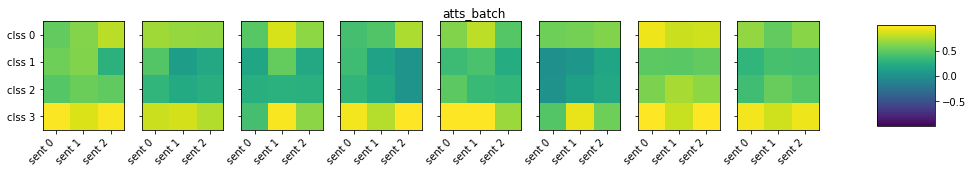

entity                                           logits             p  \
0    foo  [-4.2319193, -6.2863164, -4.3405404, -4.351577]  [0, 0, 0, 0]   
1    foo   [-3.148034, -1.8299935, 0.25843644, -2.793015]  [0, 0, 1, 0]   
2    foo  [0.66864717, 0.71031135, 1.2330692, -1.7185396]  [1, 1, 1, 0]   
3    foo    [2.4539285, 0.7389173, 1.1229917, -0.6139941]  [1, 1, 1, 0]   
4    foo    [-3.3533483, -5.738952, -4.147429, -4.977519]  [0, 0, 0, 0]   
5    foo  [-3.7299397, -3.8708858, -3.715755, -3.3017354]  [0, 0, 0, 0]   
6    foo   [-1.221123, -2.2450173, -2.0429044, -3.017924]  [0, 0, 0, 0]   
7    foo     [3.1425843, 1.0073711, 1.8892046, 3.7114806]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and, rachael

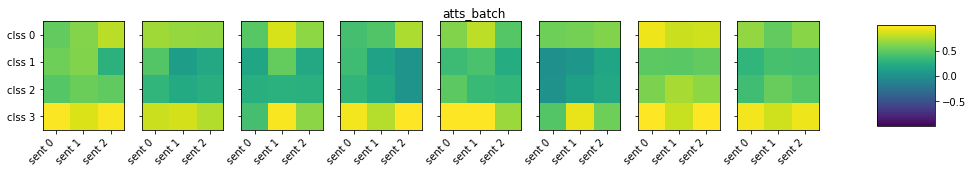

Epoch 18


entity                                              logits             p  \
0    foo       [-6.805927, -10.99963, -9.138571, -5.5041842]  [0, 0, 0, 0]   
1    foo      [-1.1631306, -2.5707645, -1.923714, -3.537232]  [0, 0, 0, 0]   
2    foo      [-9.204639, -21.628998, -14.358643, -8.741109]  [0, 0, 0, 0]   
3    foo        [1.4438802, 0.7660603, 1.1963642, 2.2611108]  [1, 1, 1, 1]   
4    foo      [-3.839951, -7.2025256, -5.240568, -4.5277514]  [0, 0, 0, 0]   
5    foo      [-1.4144987, -3.818275, -4.164803, -2.4704084]  [0, 0, 0, 0]   
6    foo      [4.084585, -0.42204416, -0.9966172, 0.7894546]  [1, 0, 0, 1]   
7    foo  [0.47731698, -0.15026212, -0.29865205, -1.5931133]  [1, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [1, 1, 1, 1]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [1, 0, 0, 0]   
7  [1, 0, 1, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                sents  
0                             [[the, weld, county,, colorado, department, of, public, health,, where, greeley, is, located,, reported, that, employees, had, said, that, the, jbs, plant, had, a, "work, while, sick", culture., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [greeley, is, the, home, rule, municipality, that, is, the, county, seat, and, the, most, populous, municipality, of, weld, county,, colorado,, united, states., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [north, colorado, medical, center, is, the, primary, medical, facility, for, weld, county., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                [[it, was, nominated, for, the, grammy, award, for, best, spoken, word, album., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <u

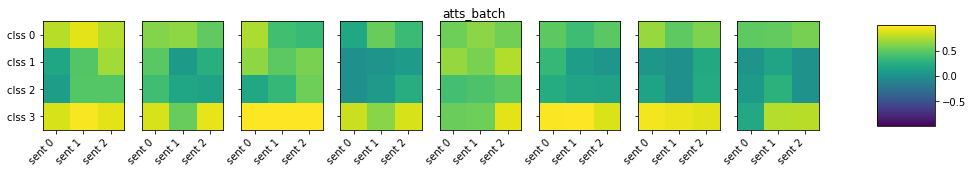

entity                                           logits             p  \
0    foo  [-4.6731243, -4.674712, -3.6302161, -4.1968365]  [0, 0, 0, 0]   
1    foo  [-3.4834282, -1.0636026, 0.5431632, -2.7297473]  [0, 0, 1, 0]   
2    foo   [0.23565793, 0.7962675, 1.3123959, -1.7557604]  [1, 1, 1, 0]   
3    foo  [2.1259923, 0.78500384, 1.1626723, -0.67550063]  [1, 1, 1, 0]   
4    foo    [-3.5227222, -5.07974, -3.8470054, -4.886455]  [0, 0, 0, 0]   
5    foo  [-4.015624, -3.3494296, -3.5642571, -3.2069945]  [0, 0, 0, 0]   
6    foo  [-1.4705502, -1.9806889, -1.854468, -2.9798093]  [0, 0, 0, 0]   
7    foo     [2.3422272, 1.0344502, 1.9086102, 3.8232422]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and, rachael

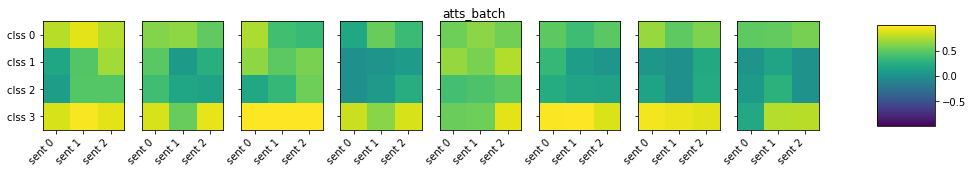

Epoch 19


entity                                            logits             p  \
0    foo  [1.1425982, 0.69695675, 0.5358745, -0.022818446]  [1, 1, 1, 0]   
1    foo      [1.143975, 0.92469585, 1.3580229, 1.9584814]  [1, 1, 1, 1]   
2    foo     [-2.1209903, -2.2565174, -2.44453, -2.624332]  [0, 0, 0, 0]   
3    foo   [4.6908197, 0.51755613, 0.81657827, -1.1232867]  [1, 1, 1, 0]   
4    foo   [-4.5717096, -3.856135, -5.8046527, -4.2875237]  [0, 0, 0, 0]   
5    foo   [-2.1893897, -2.0941672, -1.2782539, -2.425581]  [0, 0, 0, 0]   
6    foo     [-1.2811, -0.5938128, -0.56700075, -2.189257]  [0, 0, 0, 0]   
7    foo   [-8.765745, -17.825674, -6.2723727, -7.3033834]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [1, 1, 0, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [1, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                sents  
0                                            [[during, the, filming, of, dr., strangelove,, kubrick, learned, that, fail, safe,, a, film, with, a, similar, theme,, was, being, produced., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [during, an, interview, in, london, in, 2002,, williams, told, michael, parkinson, that, peter, sellers, was, an, important, influence,, especially, his, multi-character, roles, in, dr., strangelove,, stating,, "it, doesn't, get, better, than, that.", <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [gene, siskel,, on, a, section, of, siskel, and, ebert's, at, the, movies, show, regarding, stanley, kubrick, films,, declared, paths, of, glory, to, be, one, of, the, all-time, great, films, and, "almost", as, good, as, kubrick's, dr., strangelove., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                  [[the, accompanying, music, video, was, shot, by, oscar, nominated, feature, film, director, stephen, frears., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk

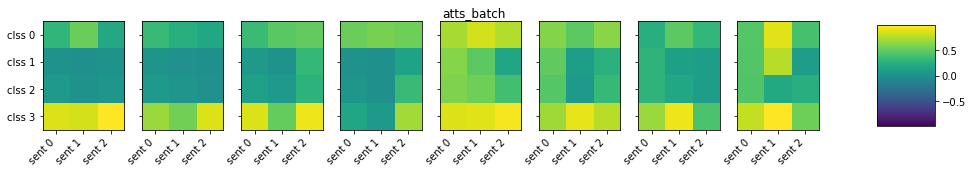

entity                                            logits             p  \
0    foo    [-5.0035224, -5.59456, -4.4821076, -4.1614366]  [0, 0, 0, 0]   
1    foo  [-3.7365499, -1.6221517, 0.13029599, -2.6926503]  [0, 0, 1, 0]   
2    foo   [0.22863519, 0.76955134, 1.1696944, -1.7011465]  [1, 1, 1, 0]   
3    foo     [2.1727562, 0.7681767, 1.057325, -0.72455955]  [1, 1, 1, 0]   
4    foo    [-3.6848984, -5.4809246, -4.310619, -4.770573]  [0, 0, 0, 0]   
5    foo   [-4.2371817, -3.4192529, -3.8910952, -3.100422]  [0, 0, 0, 0]   
6    foo  [-1.6645927, -2.1467338, -2.0361247, -2.9546318]  [0, 0, 0, 0]   
7    foo       [2.1236901, 1.0481905, 1.8726586, 3.967188]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

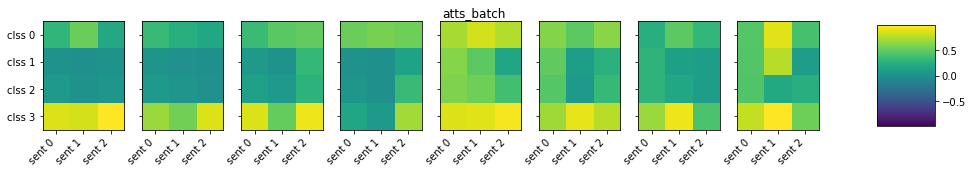

Epoch 20


entity                                            logits             p  \
0    foo      [-3.4790468, -6.079737, -7.22245, -5.448024]  [0, 0, 0, 0]   
1    foo  [-2.9752898, -2.9962387, -2.7590327, -4.9823675]  [0, 0, 0, 0]   
2    foo    [-5.226971, -9.290714, -19.729246, -7.6207876]  [0, 0, 0, 0]   
3    foo    [-0.09412587, 0.37940758, -6.831015, 2.154171]  [0, 1, 0, 1]   
4    foo      [3.1023335, 1.0306555, 1.5921535, 2.4496017]  [1, 1, 1, 1]   
5    foo     [-6.247904, -5.858931, -7.913177, -6.7138104]  [0, 0, 0, 0]   
6    foo    [-5.6055946, -5.956307, -8.618321, -5.6236067]  [0, 0, 0, 0]   
7    foo    [-9.938519, -6.939532, -13.1230135, -7.702645]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [1, 1, 0, 1]   
4  [1, 1, 1, 1]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          sents  
0  [[lewis, s., rosenstiel, award, for, distinguished, work, in, medical, research, of, brandeis, university, (co-recipient, with, craig, mello,, andrew, fire,, and, gary, ruvkun), <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [a, new, constitution, and, membership, contract, were, instituted,, and, membership, was, formally, defined, in, terms, of, the, contract, and, participating, in, the, cooperative,, rather, than, affiliation, with, brandeis, university., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [he, taught, for, a, year, at, brandeis, university, as, a, visiting, assistant, professor, and, joined, the, faculty, at, princeton, in, 2001., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                       [[boaro, joined, professional, team, carmiooro-ngc, in, the, second, half, of, 2010, as, a, stagiaire., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk

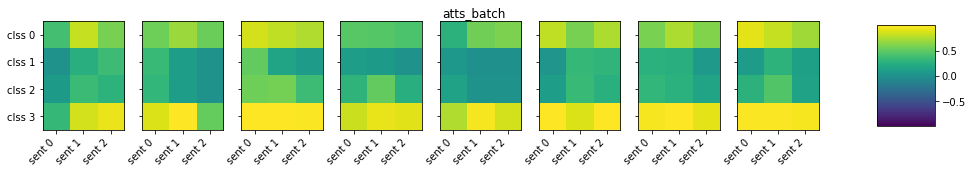

entity                                            logits             p  \
0    foo    [-4.6427526, -4.985472, -4.388641, -4.1554074]  [0, 0, 0, 0]   
1    foo  [-3.4353368, -1.4013392, 0.29817426, -2.4380527]  [0, 0, 1, 0]   
2    foo    [0.5998275, 0.80637217, 1.2075377, -1.3400782]  [1, 1, 1, 0]   
3    foo    [2.7352479, 0.7844094, 1.1011076, -0.39712906]  [1, 1, 1, 0]   
4    foo    [-3.5299702, -5.281609, -4.040948, -4.8956556]  [0, 0, 0, 0]   
5    foo    [-4.115615, -3.1886678, -3.9048405, -3.231279]  [0, 0, 0, 0]   
6    foo   [-1.4308715, -2.051518, -1.9365735, -2.9592726]  [0, 0, 0, 0]   
7    foo        [3.106766, 1.0667603, 1.9075365, 4.285921]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

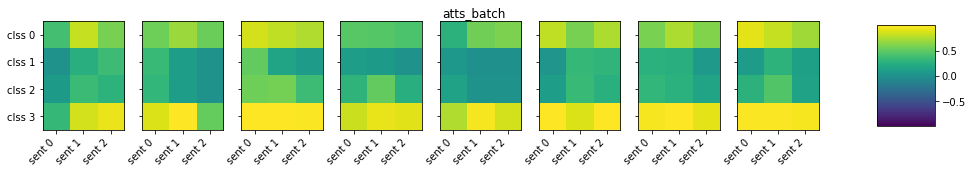

Epoch 21


entity                                           logits             p  \
0    foo     [-6.440114, -8.107327, -4.793441, -4.838016]  [0, 0, 0, 0]   
1    foo    [-4.4575486, -7.384912, -5.354193, -6.153351]  [0, 0, 0, 0]   
2    foo   [-4.339437, -7.4405713, -11.636851, -4.948167]  [0, 0, 0, 0]   
3    foo   [-3.1630986, -4.044847, -9.842735, -4.0903034]  [0, 0, 0, 0]   
4    foo  [-0.60485625, -2.0009952, -2.722581, 1.0763636]  [0, 0, 0, 1]   
5    foo  [-0.8008516, -2.960281, -3.8073206, -4.1868105]  [0, 0, 0, 0]   
6    foo    [-4.081567, -5.60702, -4.4563246, -4.6607027]  [0, 0, 0, 0]   
7    foo  [2.4267852, 0.5619977, 0.61805475, -0.67667794]  [1, 1, 1, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 1, 1, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   sents  
0                                                             [[it, is, currently, represented, by, republican, mo, brooks,, a, former, madison, county, commissioner., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [gurley, is, a, town, in, madison, county,, alabama,, united, states,, and, is, included, in, the, huntsville-decatur, combined, statistical, area., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [in, the, early, 19th, century,, several, persons, from, tennessee, explored, the, area, just, across, the, border, in, what, eventually, became, madison, county, in, alabama., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                 [[boone, attended, and, played, college, football, at, the, university, of, cincinnati, from, 2014–2017., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>

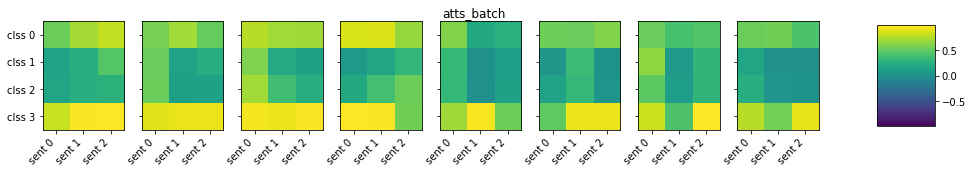

entity                                             logits             p  \
0    foo   [-5.2073154, -6.9635644, -4.5038404, -3.9970384]  [0, 0, 0, 0]   
1    foo    [-3.9038706, -2.525519, 0.27802408, -2.5314941]  [0, 0, 1, 0]   
2    foo  [-0.037773013, 0.65845096, 1.1788223, -1.4954231]  [0, 1, 1, 0]   
3    foo       [1.9857929, 0.726176, 1.0883355, -0.7059157]  [1, 1, 1, 0]   
4    foo   [-3.6930487, -6.4098372, -4.3341875, -4.7075205]  [0, 0, 0, 0]   
5    foo        [-4.4102106, -3.723843, -4.081433, -3.0429]  [0, 0, 0, 0]   
6    foo     [-1.7999389, -2.4386504, -2.08604, -2.9414332]  [0, 0, 0, 0]   
7    foo        [1.5102415, 1.0443431, 1.8900311, 4.205165]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, rando

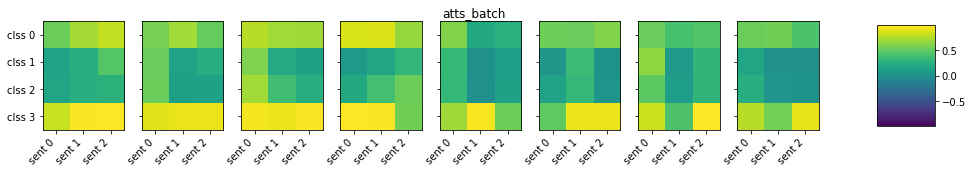

Epoch 22


entity                                            logits             p  \
0    foo  [-5.7652063, -10.581354, -7.0398197, -5.8394117]  [0, 0, 0, 0]   
1    foo  [-4.2308626, -7.3538413, -5.6592016, -7.5950136]  [0, 0, 0, 0]   
2    foo   [0.47497988, -0.6826422, -7.482789, 0.12875938]  [1, 0, 0, 1]   
3    foo    [-3.18835, -4.7989316, -5.4322166, -2.6570163]  [0, 0, 0, 0]   
4    foo     [1.0273314, 0.5574705, 0.9945832, 0.30156636]  [1, 1, 1, 1]   
5    foo     [-6.387477, -7.354262, -5.731039, -3.8605807]  [0, 0, 0, 0]   
6    foo  [-6.911193, -5.8986106, -0.70409715, -2.1950026]  [0, 0, 0, 0]   
7    foo   [-3.787636, -6.1190906, -7.5512695, -4.3206444]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [1, 1, 0, 1]   
3  [0, 0, 0, 0]   
4  [1, 1, 1, 1]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              sents  
0      [[titan,, saturn's, largest, moon,, and, the, second-largest, in, the, solar, system,, is, larger, than, the, planet, mercury,, although, less, massive,, and, is, the, only, moon, in, the, solar, system, to, have, a, substantial, atmosphere., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, abundance, of, 60ni, present, in, extraterrestrial, material, may, bring, further, insight, into, the, origin, and, early, history, of, the, solar, system., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [solar, system, –, gravitationally, bound, system, comprising, the, sun, and, the, objects, that, orbit, it,, either, directly, or, indirectly., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                      [[she, also, developed, her, artistic, talents, while, studying, painting, at, the, san, francisco, school, of, design., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk

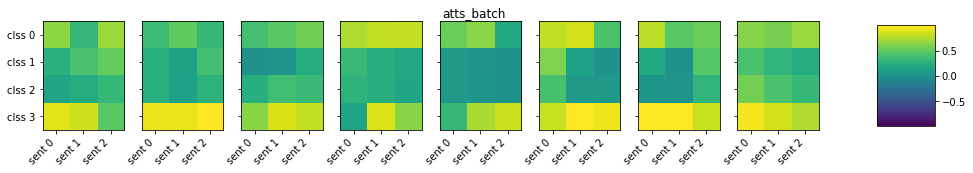

entity                                            logits             p  \
0    foo     [-4.105557, -4.641009, -3.803728, -3.8865356]  [0, 0, 0, 0]   
1    foo  [-3.1058805, -1.2131588, 0.41696835, -2.3616319]  [0, 0, 1, 0]   
2    foo     [0.6426275, 0.82471144, 1.2450264, -1.377186]  [1, 1, 1, 0]   
3    foo    [2.7627816, 0.8065741, 1.1095738, -0.63027954]  [1, 1, 1, 0]   
4    foo  [-3.2753716, -5.2593207, -3.6400752, -4.7385983]  [0, 0, 0, 0]   
5    foo    [-3.9036965, -2.9552784, -3.8334956, -3.09172]  [0, 0, 0, 0]   
6    foo   [-1.273071, -1.9191344, -1.6982704, -2.9348254]  [0, 0, 0, 0]   
7    foo       [2.7582107, 1.0858327, 1.9605186, 4.366471]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

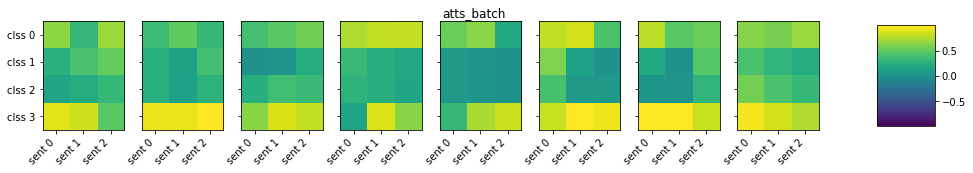

Epoch 23


entity                                            logits             p  \
0    foo      [3.5474734, 0.7559507, 1.1106745, 1.9284258]  [1, 1, 1, 1]   
1    foo  [0.5399568, -0.67486477, -1.7787374, -2.7673254]  [1, 0, 0, 0]   
2    foo  [1.7238042, 0.35265648, 0.89228153, -0.31473362]  [1, 1, 1, 0]   
3    foo    [-3.3639631, -5.040775, -6.355664, -4.0852423]  [0, 0, 0, 0]   
4    foo  [-2.4263742, -3.7055106, -3.7469802, -3.3476248]  [0, 0, 0, 0]   
5    foo     [-7.4079065, -18.2044, -12.04089, -5.7214813]  [0, 0, 0, 0]   
6    foo      [-9.76104, -8.576544, -13.863028, -9.619717]  [0, 0, 0, 0]   
7    foo     [-4.131418, -5.241244, -5.397432, -3.8310533]  [0, 0, 0, 0]   

             gt  \
0  [1, 1, 1, 1]   
1  [0, 0, 0, 0]   
2  [1, 1, 1, 1]   
3  [0, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           sents  
0                                                               [[kevin, malone, (brian, baumgartner), resolving, to, eat, more, vegetables,, ryan, howard, (b., j., novak), resolving, to, "live, life, like, it's, an, art, project,", and, creed, bratton, (creed, bratton), resolving, to, do, a, cartwheel., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, episode, featured, guest, appearances, from, recurring, actor, creed, bratton, as, well, as, from, ed, helms,, rashida, jones,, wayne, wilderson,, mike, bruner,, and, ursula, burton,, whose, characters, joined, the, scranton, branch., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [wilson, said, he, proposed, doing, a, full, studio, cover, of, the, song,, with, creed, bratton, providing, backup, guitar, and, vocals,, and, selling, it, on, itunes, for, charity., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                                                                        [[howards, end, was, placed, on, more, top, ten, lists, than, any, other, film, in, 1992,, edging, out, the, player, and, unforgiven., <unk>, <unk>, <unk>

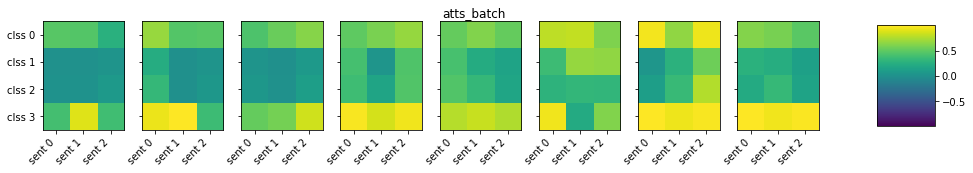

entity                                            logits             p  \
0    foo     [-5.2455425, -4.960225, -4.521944, -4.107347]  [0, 0, 0, 0]   
1    foo  [-3.8858209, -1.6273661, 0.13453436, -2.3993251]  [0, 0, 1, 0]   
2    foo   [0.07028031, 0.79496765, 1.1442839, -1.2385098]  [1, 1, 1, 0]   
3    foo   [2.3708181, 0.78919566, 1.0996821, -0.30446565]  [1, 1, 1, 0]   
4    foo     [-3.67913, -5.2082033, -4.1097507, -4.918218]  [0, 0, 0, 0]   
5    foo    [-4.473419, -2.9600701, -4.130395, -3.1832688]  [0, 0, 0, 0]   
6    foo  [-1.7601475, -1.8946981, -1.8773451, -3.0230513]  [0, 0, 0, 0]   
7    foo      [1.6443167, 1.0818049, 1.9381479, 4.5452886]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

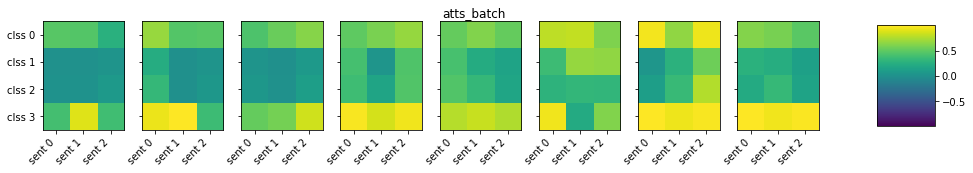

Epoch 24


entity                                            logits             p  \
0    foo   [-5.284258, -5.8642597, -4.2219496, -4.8546815]  [0, 0, 0, 0]   
1    foo  [-0.42056084, 0.4053762, -0.5935862, -1.3374705]  [0, 1, 0, 0]   
2    foo     [-0.7199975, 0.35423148, 1.04227, -0.6854162]  [0, 1, 1, 0]   
3    foo      [-6.744366, -7.87743, -11.539572, -4.673639]  [0, 0, 0, 0]   
4    foo      [-5.587878, -7.237691, -5.075489, -4.762734]  [0, 0, 0, 0]   
5    foo   [-2.8456132, -3.6337848, -5.0702324, -4.034048]  [0, 0, 0, 0]   
6    foo   [-0.7289554, 0.77956736, 1.2804127, 0.80092394]  [0, 1, 1, 1]   
7    foo   [-3.8599596, -4.1197357, -4.803728, -3.2108512]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [1, 1, 0, 1]   
2  [1, 1, 1, 1]   
3  [0, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [1, 1, 1, 1]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    sents  
0                         [[introduced, as, the, mil, gl, (for, "militarisiert, geländegängig", -, military,, cross, country, mobile),, the, man, kat, 1, series, is, used, by, all, branches, of, the, bundeswehr., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, coast, guard, may,, varying, by, jurisdiction,, be, a, branch, of, a, country's, military,, a, law, enforcement, agency,, or, a, search, and, rescue, body., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [carell, reunited, with, greg, daniels, for, the, netflix, workplace, comedy, series, space, force,, based, on, the, proposed, space, warfare, service, branch, of, the, united, states, armed, forces:, the, united, states, space, force., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1               [[also, in, 1990,, baz, luhrmann's, la, bohème, premiered, in, sydney,, establishing, cheryl, barker, and, david, hobson, as, important, principals, in, the, company., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <un

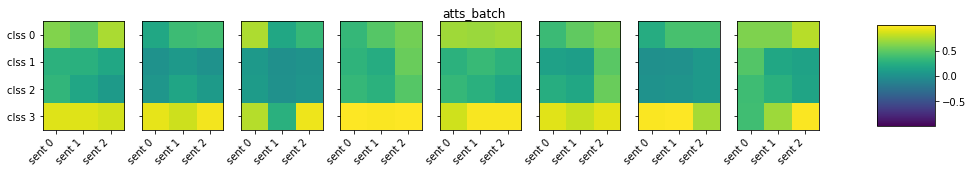

entity                                            logits             p  \
0    foo    [-5.211982, -5.0862193, -4.295219, -4.1461105]  [0, 0, 0, 0]   
1    foo   [-3.8977733, -1.5745217, 0.3001883, -2.6162467]  [0, 0, 1, 0]   
2    foo     [0.65821004, 0.8047123, 1.184072, -1.6555711]  [1, 1, 1, 0]   
3    foo    [3.3133333, 0.7904613, 1.1186843, -0.74623656]  [1, 1, 1, 0]   
4    foo   [-3.7184758, -5.5036345, -4.123736, -4.8154182]  [0, 0, 0, 0]   
5    foo    [-4.4985933, -3.0067096, -4.001406, -3.030149]  [0, 0, 0, 0]   
6    foo  [-1.6180546, -1.9840785, -1.8042581, -3.0213552]  [0, 0, 0, 0]   
7    foo       [2.7977874, 1.0990932, 1.9457326, 4.261935]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

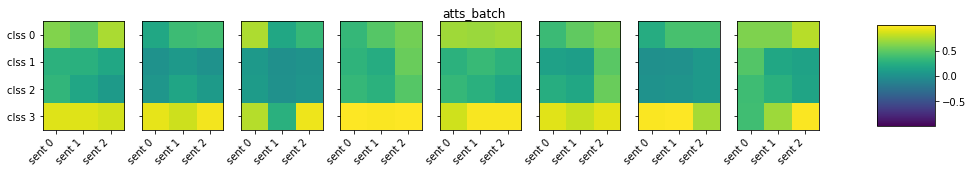

Epoch 25


entity                                             logits             p  \
0    foo   [-4.1055927, -2.5280461, -1.6802907, -1.4505932]  [0, 0, 0, 0]   
1    foo       [4.1608152, 1.0315363, 1.8596104, 3.9026263]  [1, 1, 1, 1]   
2    foo      [-8.55847, -12.231746, -17.140844, -8.040773]  [0, 0, 0, 0]   
3    foo   [-3.0247235, -0.6693052, -0.6811979, -2.2697213]  [0, 0, 0, 0]   
4    foo     [2.272864, 0.48679203, 0.28632855, -1.5394936]  [1, 1, 1, 0]   
5    foo   [-0.5594425, 0.16531777, 0.03808403, 0.27925038]  [0, 1, 1, 1]   
6    foo  [-0.60337234, -3.6820698, -3.4730783, -2.5524268]  [0, 0, 0, 0]   
7    foo    [-3.419261, -1.9670678, -3.4349704, -4.4391866]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [1, 1, 1, 1]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [1, 0, 1, 0]   
5  [1, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0             [[shortly, after, joining, entertainment, tonight, in, 1994,, julie, was, named, one, of, people, magazine’s, “50, most, beautiful, people., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [previously,, she, served, as, a, segment, producer, for, entertainment, tonight, since, 2001., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [ausiello, has, also, contributed, commentary, to, media, outlets, outside, of, tv, guide,, such, as, today,, good, morning, america,, fox, &, friends,, american, morning,, inside, edition,, extra,, access, hollywood,, and, entertainment, tonight., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                      [[comedian, steve, goodie, wrote, and, recorded, a, parody, of, the, song, titled, "ned, beatty, had, the, hardest, part,", which, became, a, staple, on, radio, morning, shows,, like, the, bob, &, tom, show,, in, the, mid-1990s., <unk>, 

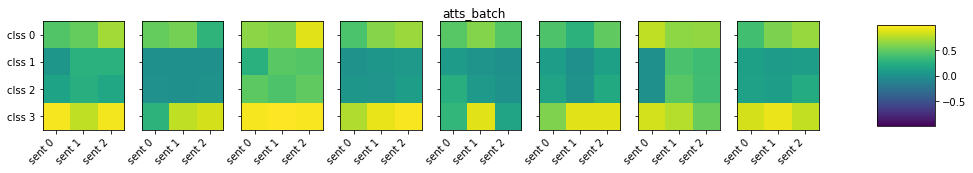

entity                                            logits             p  \
0    foo    [-4.6782055, -6.041218, -3.3381336, -4.257663]  [0, 0, 0, 0]   
1    foo    [-3.5124733, -2.1081872, 0.7008536, -2.646628]  [0, 0, 1, 0]   
2    foo   [0.006394744, 0.7436298, 1.3504198, -1.5775316]  [1, 1, 1, 0]   
3    foo     [2.3463674, 0.785999, 1.2010598, -0.66285396]  [1, 1, 1, 0]   
4    foo   [-3.4255033, -6.058486, -3.4767601, -4.9637814]  [0, 0, 0, 0]   
5    foo    [-4.318746, -3.1824203, -3.767039, -3.1236897]  [0, 0, 0, 0]   
6    foo  [-1.5358661, -2.1407151, -1.5806143, -3.0575821]  [0, 0, 0, 0]   
7    foo      [1.8187908, 1.1034096, 2.0150692, 4.2390704]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

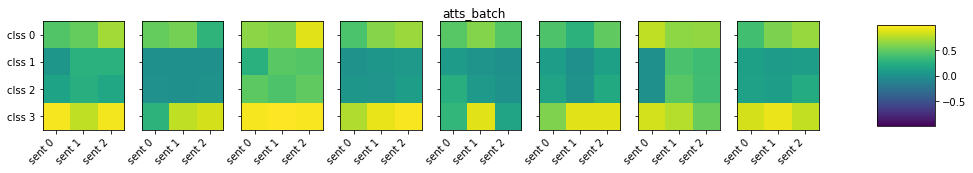

Epoch 26


entity                                             logits             p  \
0    foo     [-7.059836, -11.981917, -12.363774, -8.147451]  [0, 0, 0, 0]   
1    foo     [-5.723213, -6.5725336, -11.184276, -5.677315]  [0, 0, 0, 0]   
2    foo    [-2.2984574, -5.1508226, -3.7558086, -2.938899]  [0, 0, 0, 0]   
3    foo      [-2.4885497, -4.105099, -5.069063, -5.823653]  [0, 0, 0, 0]   
4    foo  [-1.3480389, -0.9374677, -1.6034634, -0.49901152]  [0, 0, 0, 0]   
5    foo      [-4.790152, -2.386313, -7.4068317, -6.095664]  [0, 0, 0, 0]   
6    foo    [-4.0531254, -7.8837013, -4.7410192, -7.303569]  [0, 0, 0, 0]   
7    foo     [2.9319754, 0.65833026, 0.4966731, -1.1054586]  [1, 1, 1, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                sents  
0                                                                        [[by, the, 9th, century,, catalan, had, evolved, from, vulgar, latin, on, both, sides, of, the, eastern, end, of, the, pyrenees,, as, well, as, the, territories, of, the, roman, province, of, hispania, tarraconensis, to, the, south., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [poctefa, 2014-2020, created, to, promote, the, sustainable, development, of, the, border, territories, of, the, three, countries, on, both, sides, of, the, pyrenees., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [at, first,, some, of, the, exfiltrations, to, spain, were, by, sea,, but, the, more, common, route, was, for, local, guides, (often, smugglers, familiar, with, the, pyrenees),, to, accompany, the, soldiers, and, airmen, on, foot, across, the, border, to, spain., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                  [[he, made, over, 100, appearances, for, aberdeen, before, joining, forfar, athletic, in, 1962., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <u

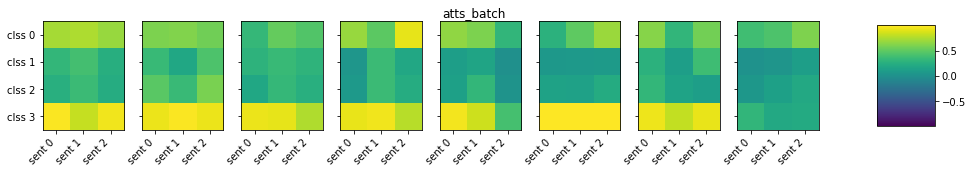

entity                                           logits             p  \
0    foo     [-4.882601, -5.875325, -4.898099, -4.185508]  [0, 0, 0, 0]   
1    foo   [-3.613176, -2.1479425, 0.12949765, -2.620594]  [0, 0, 1, 0]   
2    foo    [0.2505052, 0.7770089, 1.1172129, -1.6853011]  [1, 1, 1, 0]   
3    foo   [3.1512434, 0.78458387, 1.0833118, -0.7741606]  [1, 1, 1, 0]   
4    foo   [-3.545865, -5.983927, -4.2672715, -4.9072967]  [0, 0, 0, 0]   
5    foo    [-4.464759, -3.1552405, -4.4278307, -3.11908]  [0, 0, 0, 0]   
6    foo  [-1.5600762, -2.2127156, -1.927103, -3.0312057]  [0, 0, 0, 0]   
7    foo         [2.3434756, 1.1041785, 1.9487376, 4.195]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and, rachael

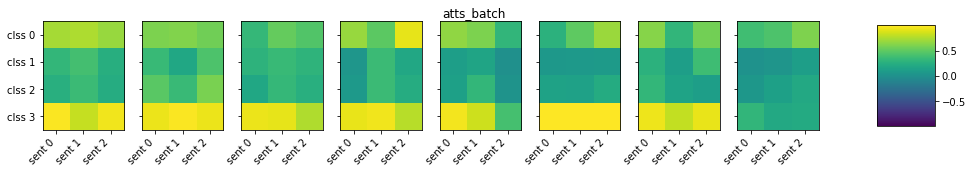

Epoch 27


entity                                            logits             p  \
0    foo   [-2.5384054, -3.4177804, -5.7667556, -4.790062]  [0, 0, 0, 0]   
1    foo    [-0.01935625, 1.0955486, 1.9315346, 4.7854877]  [0, 1, 1, 1]   
2    foo     [-3.582665, -8.277105, -14.017711, -6.766833]  [0, 0, 0, 0]   
3    foo     [-9.35488, -9.474909, -19.669872, -6.7364297]  [0, 0, 0, 0]   
4    foo     [-5.6867065, -10.506405, -9.319706, -5.54049]  [0, 0, 0, 0]   
5    foo  [-3.9323673, -4.9086733, -11.001698, -4.4364214]  [0, 0, 0, 0]   
6    foo  [-3.8769212, -3.3475337, -2.2683873, -3.2184112]  [0, 0, 0, 0]   
7    foo    [-7.973588, -10.403471, -9.081039, -6.9804606]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [1, 1, 1, 1]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    sents  
0                                                                                  [[he, stars, in, matching, jack,, which, was, released, in, august, 2010,, and, legend, of, the, guardians:, the, owls, of, ga'hoole,, released, in, september, 2010., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [an, elf, owl, named, gylfie, is, a, major, character, in, the, guardians, of, ga'hoole, book, series, by, kathryn, lasky,, and, the, 2010, film, adaptation., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [beanie, babies, have, also, been, produced, for, characters, from, legend, of, the, guardians:, the, owls, of, ga'hoole, and, guardians, of, ga'hoole, book, series,, scooby-doo,, hello, kitty,, and, peanuts., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[angela, bassett,, gabourey, sidibe,, and, danny, huston, guest, star, as, marie, laveau,, queenie,, and, the, axeman,, respectively., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <

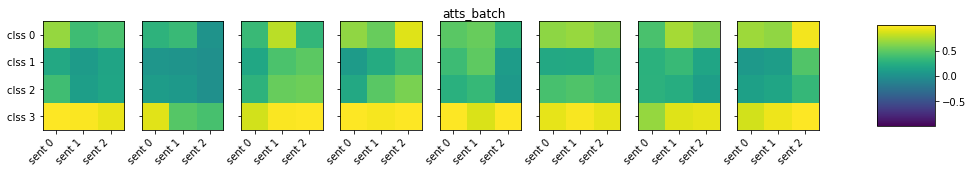

entity                                            logits             p  \
0    foo   [-5.0051603, -4.370854, -4.4830637, -4.5992694]  [0, 0, 0, 0]   
1    foo   [-3.697013, -1.2696838, 0.23726511, -2.9501572]  [0, 0, 1, 0]   
2    foo    [0.44935822, 0.84515965, 1.1763186, -2.145649]  [1, 1, 1, 0]   
3    foo    [3.4573934, 0.8238923, 1.1301343, -0.88998246]  [1, 1, 1, 0]   
4    foo     [-3.624271, -5.306338, -4.1831293, -5.219583]  [0, 0, 0, 0]   
5    foo    [-4.578966, -2.719662, -4.2164507, -3.1728542]  [0, 0, 0, 0]   
6    foo  [-1.6406878, -1.8936958, -1.8339331, -3.2165036]  [0, 0, 0, 0]   
7    foo       [2.4444668, 1.1097076, 1.9758155, 3.743112]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

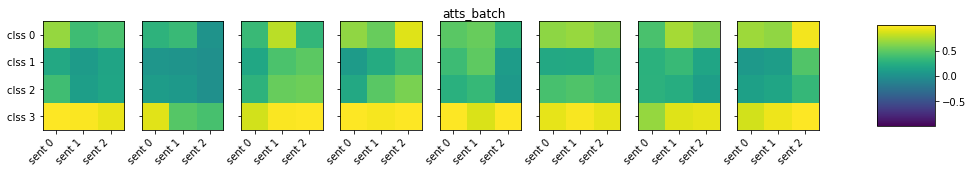

Epoch 28


entity                                             logits             p  \
0    foo   [-1.9647584, 0.23021066, -0.30741858, 2.1141706]  [0, 1, 0, 1]   
1    foo  [-0.87684166, 0.33134466, -1.6543624, -1.2775443]  [0, 1, 0, 0]   
2    foo   [-5.1591063, -1.5688391, -5.3591957, -4.0811543]  [0, 0, 0, 0]   
3    foo    [-3.6324897, -3.8631597, -2.374068, -4.7640357]  [0, 0, 0, 0]   
4    foo    [-2.9355946, -1.7291198, -4.8938227, -3.204812]  [0, 0, 0, 0]   
5    foo   [-10.01823, -15.002577, -19.160652, -12.5234585]  [0, 0, 0, 0]   
6    foo      [-5.1066628, -6.525329, -6.018285, -5.245988]  [0, 0, 0, 0]   
7    foo     [-11.08667, -12.128027, -28.311983, -9.187054]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 1, 1]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     sents  
0                                [[miller, directed, a, star-studded, cast, which, includes, robin, wright,, alan, arkin,, keanu, reeves,, winona, ryder, and, julianne, moore., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [interrupted,, opposite, winona, ryder, and, angelina, jolie,, and, a, minor, part, in, the, drama, the, same, year,, she, had, a, small, role, in, the, movie, mumford, (1999),, playing, the, daughter, of, a, woman, with, a, shopping, addiction., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [during, her, early, journalistic, days,, frost, interviewed, a, variety, of, people,, including, julia, child,, pauline, kael,, and, winona, ryder., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                                            [[her, screenplay, about, aung, san, suu, kyi,, the, lady,, directed, by, luc, besson, and, starring, michelle, yeoh, and, david, thewlis, was, awarded, the, amnesty, international, human, rights, film, award, in, 2011., <unk>, <unk>, <unk>, <unk>, 

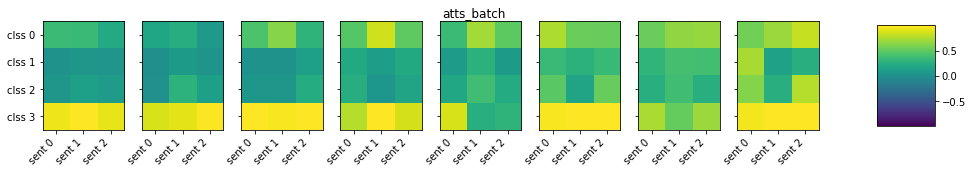

entity                                           logits             p  \
0    foo  [-5.1395893, -6.6299353, -4.408007, -4.5551796]  [0, 0, 0, 0]   
1    foo   [-3.7675986, -2.4550474, 0.3910122, -2.914716]  [0, 0, 1, 0]   
2    foo  [0.06606412, 0.75552636, 1.2170362, -2.1588125]  [1, 1, 1, 0]   
3    foo    [3.0187728, 0.7763906, 1.1394219, -0.8856052]  [1, 1, 1, 0]   
4    foo  [-3.6325018, -6.6111393, -4.212909, -5.1710415]  [0, 0, 0, 0]   
5    foo   [-4.6632123, -3.1543257, -4.15895, -3.1128526]  [0, 0, 0, 0]   
6    foo  [-1.7445078, -2.2064757, -1.8445797, -3.192213]  [0, 0, 0, 0]   
7    foo     [1.8781073, 1.1123767, 1.9672457, 3.8541343]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and, rachael

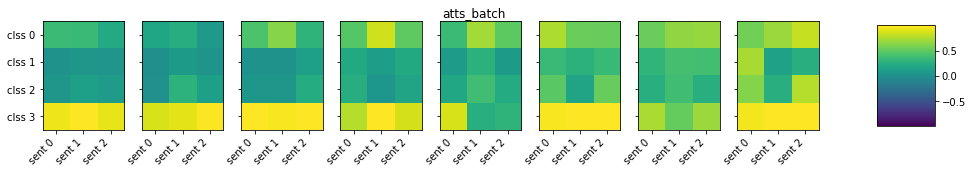

Epoch 29


entity                                              logits             p  \
0    foo         [-7.659111, -8.692674, -5.463969, -6.60096]  [0, 0, 0, 0]   
1    foo  [-0.8554853, -0.7126095, -0.009409666, -2.0703237]  [0, 0, 0, 0]   
2    foo    [-2.1983902, -3.0491922, -1.1283166, -3.1114671]  [0, 0, 0, 0]   
3    foo     [-3.6276278, -4.3851824, -6.220145, -5.1223507]  [0, 0, 0, 0]   
4    foo      [-1.9683064, -2.63438, -3.2590947, -2.7561088]  [0, 0, 0, 0]   
5    foo      [-4.9906683, -8.057441, -5.1010017, -5.522252]  [0, 0, 0, 0]   
6    foo        [0.43153763, 1.0231515, 1.7762232, 2.139346]  [1, 1, 1, 1]   
7    foo       [-5.8332367, -7.2472258, -8.79783, -6.866953]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 1, 1, 1]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  sents  
0                                               [[ultimately,, the, team, decided, to, retain, the, yankees, moniker, but, to, call, itself, the, staten, island, pizza, rats, for, select, games, as, an, alternate, identity., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [while, the, route, via, staten, island,, estimated, at, $35, million,, could, potentially, accommodate, a, passenger, line, at, a, cost, of, another, $28, million,, other, costs, made, the, direct, route, cheaper., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [not, only, did, titone, provide, legal, support, and, guidance, for, the, family,, he, also, helped, the, young, man, establish, the, justin, ligreci, hiv/aids, foundation, for, children, and, teens,, a, not, for, profit, organization, that, provides, educational, services, to, the, youth, of, staten, island, and, new, york, metropolitan, area., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                                     [[the, material, was, passed, to, mike, chavez, of, geffen, records,, who, gave, it, to, snoop, dogg., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>,

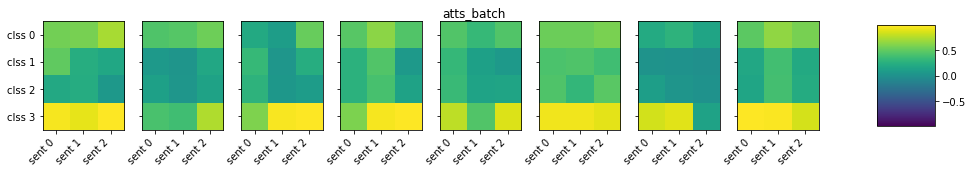

entity                                           logits             p  \
0    foo   [-4.759604, -6.082241, -4.3932123, -4.1055994]  [0, 0, 0, 0]   
1    foo  [-3.4493425, -2.195321, 0.27962577, -2.5126715]  [0, 0, 1, 0]   
2    foo   [0.51892805, 0.73594224, 1.1505814, -1.574535]  [1, 1, 1, 0]   
3    foo    [3.782625, 0.79559153, 1.1177077, -0.6578227]  [1, 1, 1, 0]   
4    foo   [-3.516822, -6.2392106, -3.9867225, -4.870996]  [0, 0, 0, 0]   
5    foo   [-4.5063696, -3.1075907, -4.145707, -3.026864]  [0, 0, 0, 0]   
6    foo    [-1.5313733, -2.0344954, -1.771379, -3.02527]  [0, 0, 0, 0]   
7    foo        [2.6193826, 1.117833, 1.9930637, 4.56012]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and, rachael

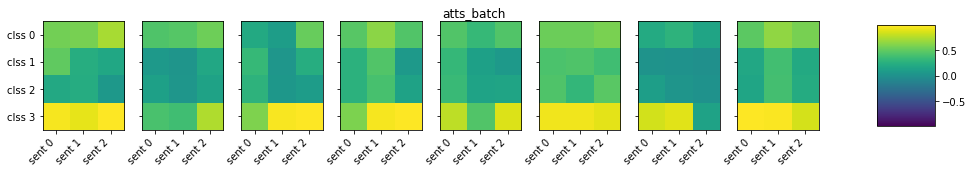

Epoch 30


entity                                           logits             p  \
0    foo   [-9.58478, -21.133549, -14.654655, -10.408448]  [0, 0, 0, 0]   
1    foo   [-7.131995, -14.394075, -13.640463, -8.273778]  [0, 0, 0, 0]   
2    foo    [-8.227269, -8.646082, -5.431302, -4.2706013]  [0, 0, 0, 0]   
3    foo     [-4.461154, -5.206366, -3.4199042, -2.20165]  [0, 0, 0, 0]   
4    foo     [-3.9119508, -2.95542, -3.557188, -3.303598]  [0, 0, 0, 0]   
5    foo   [-6.5271006, -9.553498, -6.3968444, -4.962516]  [0, 0, 0, 0]   
6    foo  [-3.0992167, -4.910941, -5.5350256, -5.1725793]  [0, 0, 0, 0]   
7    foo   [-5.357522, -9.949402, -10.090296, -6.8683953]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           sents  
0        [[the, film, also, won, the, bafta, award, for, best, special, visual, effects, at, the, 65th, bafta, awards, in, 2012., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [she, received, three, academy, award, nominations, for, the, first,, fourth,, and, seventh, films,, as, well, as, a, bafta, and, critics, choice, award, nomination, for, the, eighth"'hugo',, 'the, artist', top, nominees, for, critics, choice, awards",, l.a., times, blog, (december, 2011), in, the, series,, which, went, on, to, win, the, american, art, directors, guild's, contribution, to, cinematic, imagery, in, 2012., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [it, received, twelve, nominations, at, the, 65th, british, academy, film, awards,, winning, seven, awards,, including, best, film,, best, director,, and, best, actor., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1               [[the, city's, status, as, the, capital, of, the, mexican, territory, of, santa, fe, de, nuevo, méxico, was, formalized, in, the, 1824, constitution, after, mexico, achieved, independence, from, spain., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <u

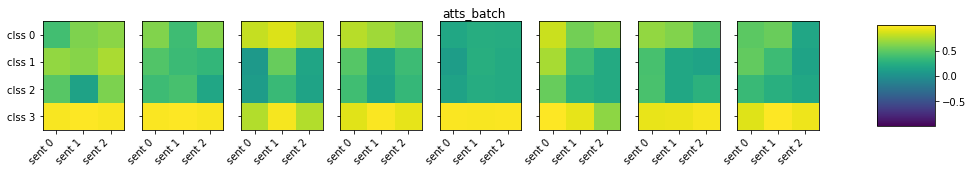

entity                                            logits             p  \
0    foo     [-5.115041, -5.5522842, -4.299656, -4.542251]  [0, 0, 0, 0]   
1    foo     [-3.708645, -1.951564, 0.3798915, -2.7521324]  [0, 0, 1, 0]   
2    foo  [-0.43636715, 0.78571475, 1.2472123, -1.8219202]  [0, 1, 1, 0]   
3    foo   [2.3959427, 0.78889436, 1.1634542, -0.64061546]  [1, 1, 1, 0]   
4    foo  [-3.5520406, -5.9115844, -3.9197392, -5.1905785]  [0, 0, 0, 0]   
5    foo  [-4.7464533, -2.9156842, -4.1202836, -3.1616373]  [0, 0, 0, 0]   
6    foo  [-1.7150811, -2.0393028, -1.7205968, -3.1885166]  [0, 0, 0, 0]   
7    foo       [1.4362934, 1.1287001, 2.0477448, 4.212436]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

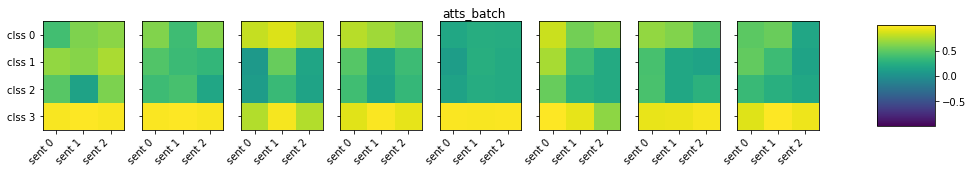

Epoch 31


entity                                              logits             p  \
0    foo         [-5.236687, -6.95524, -12.41564, -6.458744]  [0, 0, 0, 0]   
1    foo    [-6.6051154, -12.249507, -12.444267, -5.8213124]  [0, 0, 0, 0]   
2    foo       [-3.6516013, -6.863521, -5.9285927, -4.42375]  [0, 0, 0, 0]   
3    foo       [-5.054903, -5.0665956, -8.862635, -4.379914]  [0, 0, 0, 0]   
4    foo     [-3.6550732, -4.9686046, -2.2878237, -6.082992]  [0, 0, 0, 0]   
5    foo       [1.5874062, 0.16911238, -0.397089, -2.758766]  [1, 1, 0, 0]   
6    foo  [0.04989004, -0.19218242, -7.3599343, -0.24295354]  [1, 0, 0, 0]   
7    foo       [-3.7780452, -6.27309, -3.7185416, -5.614359]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [1, 1, 1, 0]   
6  [1, 1, 0, 1]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        sents  
0                                                                            [[amazon.co.uk, also, benefits, from, luxembourg, tax, loopholes, by, channeling, substantial, uk, revenues, as, reported, by, the, guardian, in, april, 2012., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [he, was, a, member, of, the, third, generation, of, owners, of, the, family, pottery, business,, jean-françois, boch, which, at, that, time, had, its, headquarters, at, siebenbrunnen, a, short, distance, to, the, north, of, luxembourg, city., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [from, 1994, to, 1996,, two, more, sections, were, opened,, bypassing, the, south-east, of, luxembourg, city, and, connecting, the, a1, to, the, croix, de, gasperich,, where, it, meets, the, a3, (to, dudelange), and, a6, (towards, arlon,, in, belgium)., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[augustów, is, a, village, in, the, administrative, district, of, gmina, krasne,, within, przasnysz, county,, masovian, voivodeship,, in, east-central, poland., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>

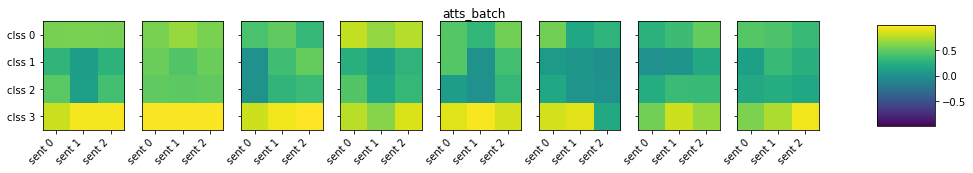

entity                                            logits             p  \
0    foo     [-4.702876, -5.083889, -4.049722, -4.6910696]  [0, 0, 0, 0]   
1    foo   [-3.4634304, -1.7330754, 0.4554267, -2.9815574]  [0, 0, 1, 0]   
2    foo     [0.2189579, 0.7809454, 1.1865785, -2.2933195]  [1, 1, 1, 0]   
3    foo      [3.6919515, 0.7985862, 1.1300851, -0.944222]  [1, 1, 1, 0]   
4    foo   [-3.3733501, -5.816038, -3.6619391, -5.2037153]  [0, 0, 0, 0]   
5    foo  [-4.5278125, -2.7382472, -4.0913615, -3.1341276]  [0, 0, 0, 0]   
6    foo   [-1.3958707, -1.977874, -1.5312183, -3.1998372]  [0, 0, 0, 0]   
7    foo       [2.390672, 1.1395689, 2.0412679, 3.8830702]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

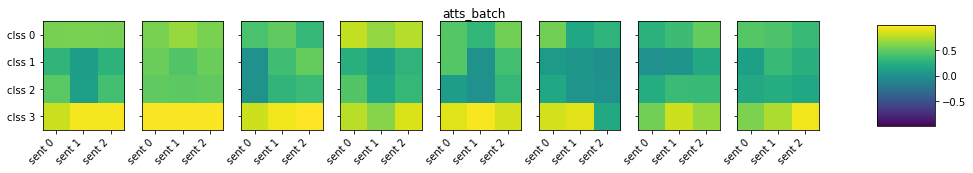

Epoch 32


entity                                              logits             p  \
0    foo        [-4.9315796, -6.52483, -8.517345, -4.922537]  [0, 0, 0, 0]   
1    foo     [-3.085197, -2.3800676, -5.4774084, -2.4811392]  [0, 0, 0, 0]   
2    foo     [-2.9614437, -4.179201, -3.5924883, -3.4448066]  [0, 0, 0, 0]   
3    foo      [-4.7281475, -10.992998, -9.413458, -6.783736]  [0, 0, 0, 0]   
4    foo       [-5.647546, -8.243837, -7.929168, -6.2205133]  [0, 0, 0, 0]   
5    foo  [0.39380574, 0.011872411, 0.22077596, -0.41758204]  [1, 1, 1, 0]   
6    foo      [-5.8831778, -8.114784, -7.342689, -5.3160267]  [0, 0, 0, 0]   
7    foo       [-4.435549, -5.8561907, -6.062755, -5.921854]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [1, 1, 1, 0]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        sents  
0  [[among, other, things,, he, drafted, the, bill, "prohibition, of, discrimination, in, products,, services, and, entry, into, places, of, entertainment, and, public, places, law",, which, was, enacted, into, law, in, 2000., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [in, march, of, the, same, year,, kmp, holdings, was, established, as, a, joint, venture, between, sm, entertainment,, yg, entertainment,, jyp, entertainment,, star, empire,, medialine,, can, entertainment,, and, music, factory., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [elevating, entertainment, has, produced, several, feature-length, films,, including, praise, band:, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                       [[the, language, belongs, to, malayic, languages,, which, is, a, malayo-polynesian, branch, of, the, austronesian, language, family., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, 

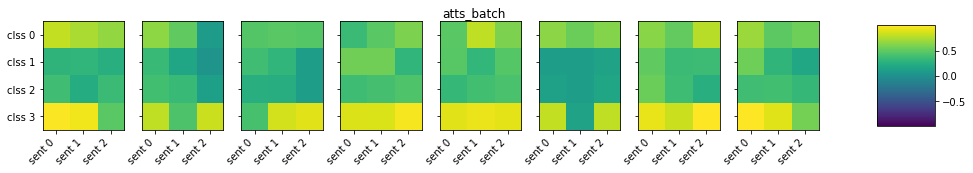

entity                                            logits             p  \
0    foo      [-4.654336, -5.842007, -4.714698, -4.434218]  [0, 0, 0, 0]   
1    foo    [-3.4491365, -2.1514807, 0.2974621, -2.852552]  [0, 0, 1, 0]   
2    foo   [-0.28227878, 0.7839623, 1.1887499, -2.1704917]  [0, 1, 1, 0]   
3    foo    [2.8431468, 0.80854535, 1.1437731, -0.9898164]  [1, 1, 1, 0]   
4    foo    [-3.383195, -6.209776, -4.1780457, -4.9994693]  [0, 0, 0, 0]   
5    foo    [-4.555502, -2.8195472, -4.1385202, -3.064436]  [0, 0, 0, 0]   
6    foo  [-1.5744588, -2.1027484, -1.7108102, -3.0947256]  [0, 0, 0, 0]   
7    foo       [1.473979, 1.1628475, 2.0584676, 4.1634283]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

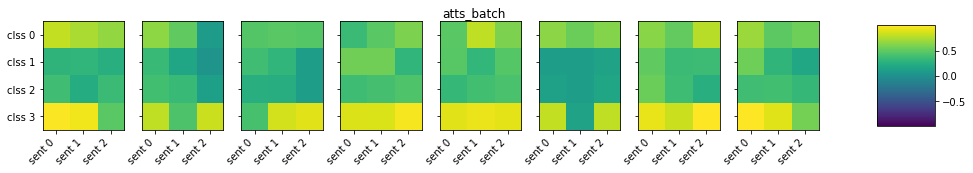

Epoch 33


entity                                             logits             p  \
0    foo      [-10.0567, -13.898684, -26.558395, -8.773063]  [0, 0, 0, 0]   
1    foo      [0.76325226, -0.3866459, -9.686879, 2.075748]  [1, 0, 0, 1]   
2    foo       [-1.892618, -8.540676, -8.198499, -5.050119]  [0, 0, 0, 0]   
3    foo     [-2.8919277, -6.681826, -8.711086, -5.8645372]  [0, 0, 0, 0]   
4    foo  [-0.81448054, -0.103993654, 1.0092717, 1.2075552]  [0, 0, 1, 1]   
5    foo   [-2.7458205, -3.1176887, -3.9156547, -1.9124829]  [0, 0, 0, 0]   
6    foo     [-5.022526, -6.823465, -4.7156277, -3.2604065]  [0, 0, 0, 0]   
7    foo   [-1.3568406, -0.027023435, -0.1902051, -1.57568]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [1, 1, 0, 1]   
2  [1, 0, 0, 1]   
3  [0, 0, 0, 0]   
4  [0, 1, 1, 1]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 1, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   sents  
0                [[southbank, centre, is, a, complex, of, artistic, venues, in, london,, england,, on, the, south, bank, of, the, river, thames, (between, hungerford, bridge, and, waterloo, bridge)., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [it, was, announced, in, the, thames, ironworks, gazette, in, june, 1895, under, the, heading, ", <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [burway, rowing, club, is, a, rowing, club, on, the, river, thames,, based, at, thameside,, laleham,, borough, of, spelthorne,, surrey., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1              [[he, was, instrumental, in, giving, veteran, actor, sunil, dutt, a, break, in, the, film, railway, platform, (1955), when, sunil, dutt, was, hosting, the, show,, lipton, ki, mehfil, on, radio, ceylon., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <

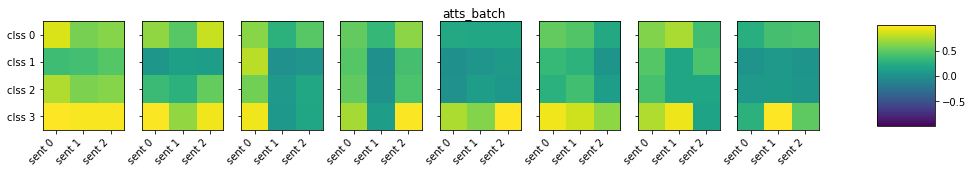

entity                                            logits             p  \
0    foo     [-5.1994305, -5.216527, -4.488277, -4.215843]  [0, 0, 0, 0]   
1    foo  [-3.7662568, -1.8125039, 0.34037995, -2.3524508]  [0, 0, 1, 0]   
2    foo   [-0.08725178, 0.8059684, 1.1356324, -1.2993665]  [0, 1, 1, 0]   
3    foo     [3.260406, 0.81456316, 1.1372699, -0.3641255]  [1, 1, 1, 0]   
4    foo       [-3.622852, -6.02606, -4.15586, -5.0634127]  [0, 0, 0, 0]   
5    foo    [-4.818878, -2.7985916, -4.335394, -3.1963267]  [0, 0, 0, 0]   
6    foo  [-1.7041723, -1.9482142, -1.7172203, -3.0854897]  [0, 0, 0, 0]   
7    foo        [1.7330875, 1.1619023, 2.059843, 4.873691]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

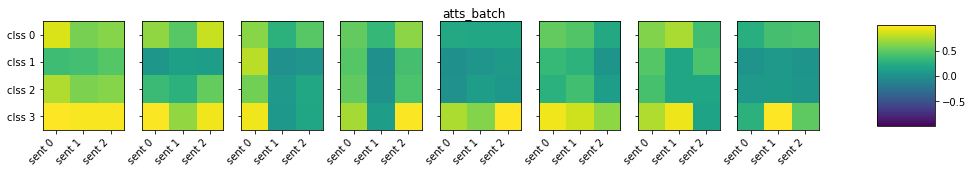

Epoch 34


entity                                            logits             p  \
0    foo    [-4.7788043, -4.839634, -6.101708, -6.8280296]  [0, 0, 0, 0]   
1    foo  [-5.1634417, -10.886813, -10.788078, -6.8201113]  [0, 0, 0, 0]   
2    foo  [-0.60638237, 0.4872911, -0.3659582, -3.2312987]  [0, 1, 0, 0]   
3    foo  [-1.1627501, -2.1053581, -3.6165156, -2.9894981]  [0, 0, 0, 0]   
4    foo     [-1.3476998, 0.8866792, 0.7914331, 2.0530396]  [0, 1, 1, 1]   
5    foo    [2.0617728, 0.78007233, 0.5262815, -0.6299722]  [1, 1, 1, 0]   
6    foo    [-7.4245844, -8.269469, -7.191282, -5.1735864]  [0, 0, 0, 0]   
7    foo    [-4.9985237, -8.409953, -7.588219, -5.8953648]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [1, 1, 1, 0]   
4  [0, 0, 0, 0]   
5  [1, 1, 0, 0]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 sents  
0                                                             [[in, 2008,, lehman, filed, for, bankruptcy,, bear, stearns, was, bought, by, jpmorgan, chase, forced, by, the, u.s., government,, and, merrill, lynch, was, bought, by, bank, of, america, in, a, similar, shot-gun, wedding., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, newspaper's, editors, changed, the, publication's, name, in, 1970, to, the, daily, nexus, to, "keep, with, the, changing, nature, of, the, university", after, protesters, burned, down, the, bank, of, america, building, in, isla, vista,, a, ucsb, community, neighboring, the, campus., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [in, june, 2012,, judge, sweet, dismissed, a, counter-suit, by, bank, of, america, corp., against, the, securities, units, of, bnp, paribas, and, deutsche, bank,, alleging, negligence, and, breach, of, fiduciary, duty, on, their, behalf, for, their, role, in, the, sale, of, notes, issued, by, ocala, funding., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                  [[the, brown, berets,, with, links, to, the, black, panther, party,, was, one, manifestation, of, the, multiracial, context, in, los, angeles., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <

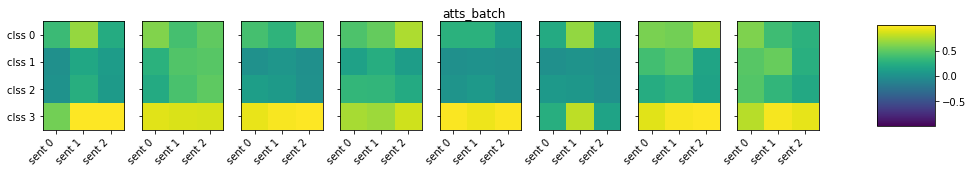

entity                                           logits             p  \
0    foo     [-5.0287294, -5.90123, -5.115886, -4.201777]  [0, 0, 0, 0]   
1    foo  [-3.5505877, -2.142639, 0.18144333, -2.5543096]  [0, 0, 1, 0]   
2    foo    [0.13270903, 0.7535218, 1.063952, -1.7690797]  [1, 1, 1, 0]   
3    foo      [3.838896, 0.78045213, 1.10324, -0.7934488]  [1, 1, 1, 0]   
4    foo    [-3.609909, -6.748192, -4.640849, -4.8973713]  [0, 0, 0, 0]   
5    foo    [-4.745405, -2.8407784, -4.356811, -2.970852]  [0, 0, 0, 0]   
6    foo  [-1.6436682, -2.198559, -1.9577556, -3.0564852]  [0, 0, 0, 0]   
7    foo       [2.165367, 1.1532964, 2.0058026, 4.597373]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and, rachael

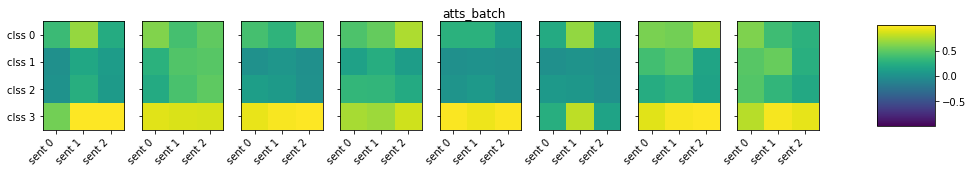

Epoch 35


entity                                            logits             p  \
0    foo     [-0.26792407, 0.7487912, 1.6242386, 4.698586]  [0, 1, 1, 1]   
1    foo      [-7.151717, -8.73899, -6.840091, -5.9169626]  [0, 0, 0, 0]   
2    foo   [-0.8989254, -0.53041744, 0.15269017, 2.938375]  [0, 0, 1, 1]   
3    foo     [-7.002302, -5.5908995, -5.285191, -7.091957]  [0, 0, 0, 0]   
4    foo    [-2.950234, -5.8129616, -6.4623113, -4.397441]  [0, 0, 0, 0]   
5    foo  [-0.29102778, -0.95524573, -7.818498, -1.864025]  [0, 0, 0, 0]   
6    foo    [-5.775488, -6.901286, -4.5531583, -4.9350567]  [0, 0, 0, 0]   
7    foo  [-1.0970435, -0.26882958, 0.2341032, -0.2925415]  [0, 0, 1, 0]   

             gt  \
0  [0, 0, 1, 1]   
1  [0, 0, 0, 0]   
2  [0, 1, 1, 1]   
3  [0, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [1, 1, 0, 0]   
6  [0, 0, 0, 0]   
7  [0, 1, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0            [[he, has, also, directed, music, videos, for, taylor, swift,, kelly, clarkson,, florida, georgia, line,, kelsea, ballerini,, cassadee, pope,, josh, groban,, thomas, rhett,, lady, antebellum,, brett, young,, danielle, bradbery,, kellie, pickler,, carly, pearce,, hunter, hayes,, maddie, &, tae,, maren, morris,, justin, bieber, and, more., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [originally, they, thought, about, giving, the, song, to, kelly, clarkson, then, daughtry;, adam, lambert, recorded, it,, but, according, to, busbee,, he, "just, wasn’t, the, right, fit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [when, kelly, heads, home, after, the, performance,, she, meets, blake, shelton, who, is, wearing, an, elf, costume., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                      [[law, enforcement, considered, the, kidnapping, of, amber, swartz, in, pinole, in, june, 1988, as, potentially, connected,, given, its, proximity, to, hayward., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>,

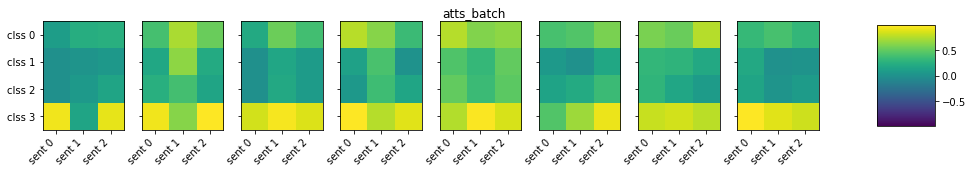

entity                                            logits             p  \
0    foo      [-5.2126465, -6.03771, -3.730318, -4.445595]  [0, 0, 0, 0]   
1    foo      [-3.777956, -2.26875, 0.6350025, -2.7443838]  [0, 0, 1, 0]   
2    foo     [-0.2368381, 0.7317053, 1.2850865, -2.093196]  [0, 1, 1, 0]   
3    foo   [3.2478938, 0.79650605, 1.1811016, -0.95716727]  [1, 1, 1, 0]   
4    foo     [-3.7331448, -6.5873213, -3.438325, -5.13259]  [0, 0, 0, 0]   
5    foo   [-4.916009, -2.8595757, -3.9323483, -3.0234036]  [0, 0, 0, 0]   
6    foo  [-1.8027701, -2.0906608, -1.4676342, -3.1435208]  [0, 0, 0, 0]   
7    foo      [1.5216112, 1.1542057, 2.0839665, 4.0933585]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

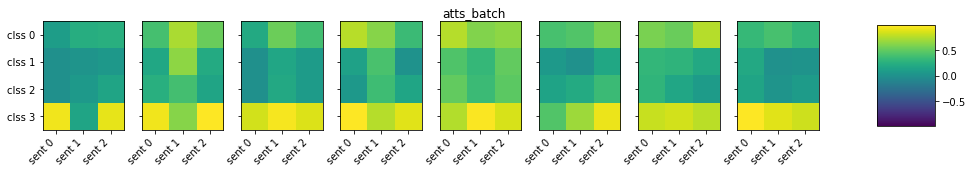

Epoch 36


entity                                           logits             p  \
0    foo    [1.6049738, 0.75737345, 1.1777422, 0.8050021]  [1, 1, 1, 1]   
1    foo  [-3.1937537, -5.3088245, -7.2980223, -6.054319]  [0, 0, 0, 0]   
2    foo    [-2.7368736, -2.9453447, -4.6407, -3.3357997]  [0, 0, 0, 0]   
3    foo   [-1.6988146, -2.935838, -0.9429884, -4.205792]  [0, 0, 0, 0]   
4    foo   [-1.8225777, -3.7870767, -4.606997, -3.191811]  [0, 0, 0, 0]   
5    foo    [-2.636959, -3.369321, -2.758892, -2.5268493]  [0, 0, 0, 0]   
6    foo     [-2.097993, -0.96996, 0.13463843, -1.392596]  [0, 0, 1, 0]   
7    foo     [-3.5384912, -6.4339, -6.546258, -3.2079048]  [0, 0, 0, 0]   

             gt  \
0  [1, 1, 1, 1]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [1, 1, 1, 1]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 sents  
0  [[in, february, 2013,, it, was, confirmed, by, the, press, that, albert, brooks, would, reprise, the, role, of, marlin, in, the, sequel., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, original, concept, was, for, a, comedy-variety, show, featuring, young, comedians,, live, musical, performances,, short, films, by, albert, brooks, and, segments, by, jim, henson, featuring, atypically, adult, and, abstract, characters, from, the, muppets, world., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [this, group, includes, rob, reiner,, al, brooks,, andre, bishop, (founder, of, playwrights, horizons, and, artistic, director, of, theatres, at, lincoln, center),, news, legend, andy, lack, (former, president, of, nbc, news,, producer, of, "60, minutes",, former, ceo, of, sony, bmg, and, current, ceo, of, the, bloomberg, lp, multimedia, group),, curtis, sliwa, (founder, of, the, guardian, angels),, jennifer, coolidge,, kitty, winn, and, corey, carrier., <unk>, <unk>]]  
1                       [[old, members, of, jesus, college, are, sometimes, known, as, "jesubites"., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>,

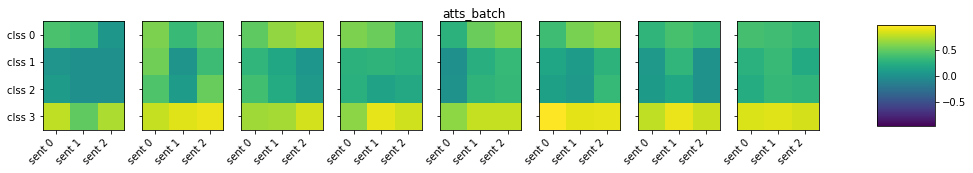

entity                                            logits             p  \
0    foo     [-4.822468, -6.4457717, -5.429963, -4.709836]  [0, 0, 0, 0]   
1    foo  [-3.5726857, -2.6026978, -0.05837941, -3.005052]  [0, 0, 0, 0]   
2    foo   [-0.045259953, 0.7365023, 0.9988284, -2.236898]  [0, 1, 1, 0]   
3    foo     [3.664665, 0.80727625, 1.0882099, -0.9257827]  [1, 1, 1, 0]   
4    foo    [-3.5285769, -6.739551, -4.663288, -5.3909163]  [0, 0, 0, 0]   
5    foo    [-4.7893095, -2.856873, -4.610244, -3.1502163]  [0, 0, 0, 0]   
6    foo    [-1.6352797, -2.2408962, -1.9384234, -3.28895]  [0, 0, 0, 0]   
7    foo      [1.6864512, 1.1836032, 2.0025468, 3.8334665]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

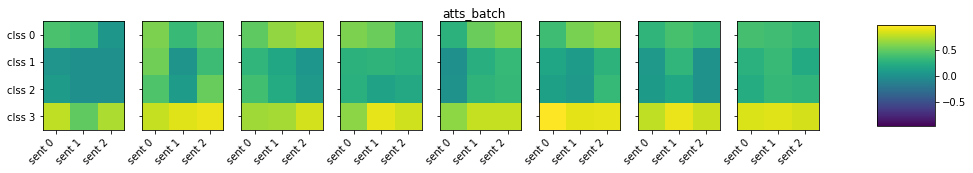

Epoch 37


entity                                             logits             p  \
0    foo    [2.6890166, -0.1279639, 0.23582411, -1.5896995]  [1, 0, 1, 0]   
1    foo    [-3.9061446, -3.6173382, -2.5959194, -4.165674]  [0, 0, 0, 0]   
2    foo    [-6.0659676, -7.348202, -11.406486, -7.9961863]  [0, 0, 0, 0]   
3    foo     [-6.9146442, -9.470988, -6.961198, -4.0288873]  [0, 0, 0, 0]   
4    foo    [2.3164322, 0.70733654, 0.19857836, -2.9004545]  [1, 1, 1, 0]   
5    foo    [-4.166834, -5.5947976, -3.8581617, -3.6158347]  [0, 0, 0, 0]   
6    foo     [-3.8706188, -5.083509, -3.691181, -3.4255056]  [0, 0, 0, 0]   
7    foo  [-1.9092342, -0.53784764, -1.7798786, -1.1981592]  [0, 0, 0, 0]   

             gt  \
0  [1, 1, 1, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [1, 1, 1, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  sents  
0  [[kennedy, chose, johnson, to, be, his, vice-presidential, running, mate,, despite, opposition, from, many, liberal, delegates, and, kennedy's, own, staff,, including, his, brother, robert, f., kennedy., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [accepting, the, "tom, paine, award", from, the, national, emergency, civil, liberties, committee, shortly, after, the, assassination, of, john, f., kennedy,, an, intoxicated, dylan, questioned, the, role, of, the, committee,, characterized, the, members, as, old, and, balding,, and, claimed, to, see, something, of, himself, and, of, every, man, in, kennedy's, assassin,, lee, harvey, oswald., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [john, f., kennedy, was, the, most, costly, carrier, in, the, fleet, to, maintain, and, was, due, for, an, expensive, overhaul;, budget, cutbacks, and, changing, naval, tactics, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                          [[forest, lawn's, founder,, dr., hubert, eaton,, and, his, staff, gave, waugh, tours, of, the, facility, and, introduced, him, to, their, field., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <un

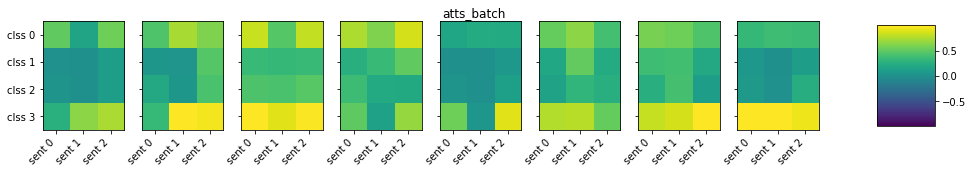

entity                                            logits             p  \
0    foo   [-4.8993464, -5.4169927, -5.0286894, -4.820799]  [0, 0, 0, 0]   
1    foo  [-3.5642824, -1.901042, 0.108406425, -3.0347998]  [0, 0, 1, 0]   
2    foo    [-0.2586596, 0.7952126, 1.0419899, -2.1523914]  [0, 1, 1, 0]   
3    foo     [3.0864255, 0.820995, 1.0908415, -0.81627727]  [1, 1, 1, 0]   
4    foo     [-3.5539126, -6.295187, -4.3330274, -5.44493]  [0, 0, 0, 0]   
5    foo    [-4.81509, -2.6103733, -4.4073296, -3.1690335]  [0, 0, 0, 0]   
6    foo   [-1.745744, -2.0694141, -1.7937775, -3.3167043]  [0, 0, 0, 0]   
7    foo         [1.32921, 1.171989, 2.0321574, 3.9641805]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

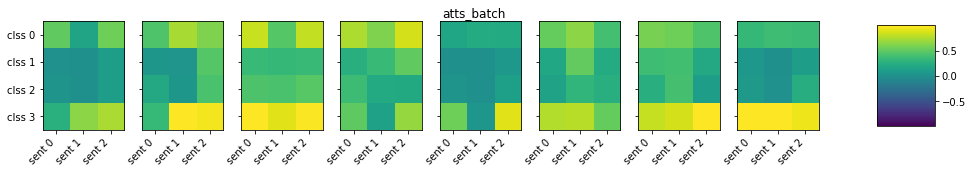

Epoch 38


entity                                           logits             p  \
0    foo   [-1.1052859, 0.59460783, 0.9205251, 4.4422355]  [0, 1, 1, 1]   
1    foo  [-2.0480099, -2.5061173, -2.942471, -2.0517752]  [0, 0, 0, 0]   
2    foo  [-5.5701313, -2.3889134, -6.943588, -6.6092367]  [0, 0, 0, 0]   
3    foo  [-1.1440194, 0.24393308, 0.6128664, -1.7556965]  [0, 1, 1, 0]   
4    foo   [-2.3373234, -3.814498, -6.403028, -2.7091577]  [0, 0, 0, 0]   
5    foo   [-7.077594, -10.089119, -13.748655, -8.071634]  [0, 0, 0, 0]   
6    foo   [-6.208209, -13.214832, -10.045429, -7.475564]  [0, 0, 0, 0]   
7    foo    [-5.624189, -9.069262, -4.636728, -4.9298987]  [0, 0, 0, 0]   

             gt  \
0  [0, 1, 1, 1]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 1, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              sents  
0                          [[bale, was, filming, with, actress, bryce, dallas, howard, when, he, berated, director, of, photography,, shane, hurlbut,, for, walking, into, his, line, of, sight., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, epilogue, deliberately, interrupts, the, closing, credits, with, rosalind's, speech,, as, the, camera, pans, to, see, rosalind's, actor,, bryce, dallas, howard,, walking, to, her, dressing, trailer, on, the, film's, location., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [she, counts, young, celebrities, and, socialites, such, as, bryce, dallas, howard,, michelle, williams,, nicole, richie,, victoria, traina, and, amber, valletta, amongst, her, best, clients., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                                    [[blinding, edge, has, produced, servant,, wayward, pines,, devil,, the, happening,, lady, in, the, water,, the, village,, signs,, unbreakable,, the, last, airbender,, after, earth,, the, visit,, split, and, glass., <unk>, <u

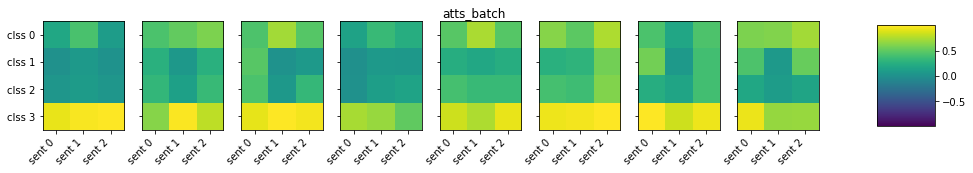

entity                                           logits             p  \
0    foo  [-5.116245, -4.9412007, -3.8782003, -4.3691897]  [0, 0, 0, 0]   
1    foo   [-3.7356958, -2.081843, 0.5171163, -2.6694207]  [0, 0, 1, 0]   
2    foo   [0.13130212, 0.7806543, 1.2313163, -1.8669047]  [1, 1, 1, 0]   
3    foo     [3.889193, 0.8089335, 1.157404, -0.82426226]  [1, 1, 1, 0]   
4    foo   [-3.6555786, -5.730903, -3.4981463, -5.050688]  [0, 0, 0, 0]   
5    foo  [-4.9307284, -2.6409307, -4.129936, -3.0475538]  [0, 0, 0, 0]   
6    foo   [-1.6153435, -1.910251, -1.479811, -3.1356416]  [0, 0, 0, 0]   
7    foo       [2.28411, 1.1630243, 2.0501182, 4.4023566]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and, rachael

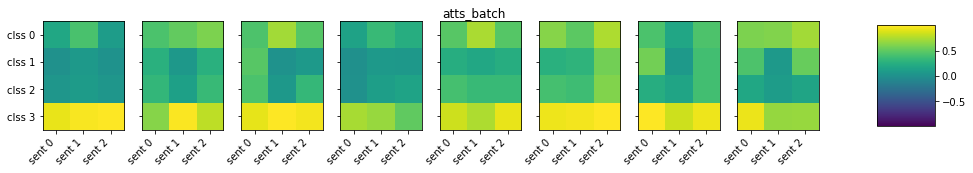

Epoch 39


entity                                            logits             p  \
0    foo  [0.21696639, -1.722915, -0.3255353, -0.54587436]  [1, 0, 0, 0]   
1    foo    [4.7386374, 1.0269306, 1.0704528, -0.03911853]  [1, 1, 1, 0]   
2    foo    [-0.9059472, 1.0277885, 1.5319328, -0.4635172]  [0, 1, 1, 0]   
3    foo   [-0.6336895, 0.06479776, -0.9175756, 2.5533934]  [0, 1, 0, 1]   
4    foo  [-0.7469188, 0.64865685, 0.90168333, 0.50290775]  [0, 1, 1, 1]   
5    foo    [-15.176083, -11.244836, -5.262209, -8.520685]  [0, 0, 0, 0]   
6    foo   [-0.11575365, -0.630949, -2.226649, -1.5308727]  [0, 0, 0, 0]   
7    foo    [-7.6044793, -9.087919, -8.227964, -6.9732943]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [1, 1, 0, 0]   
2  [0, 1, 1, 0]   
3  [1, 1, 0, 1]   
4  [0, 0, 1, 0]   
5  [0, 0, 0, 0]   
6  [1, 1, 1, 1]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               sents  
0              [[justin, lassen, has, produced, several, remixes, under, the, moniker, "empire, of, modern, thought",, including, madonna,, lady, gaga,, garbage,, blue, man, group,, fisher,, lenny, kravitz,, robert, miles,, nine, inch, nails,, linkin, park,, evanescence,, the, killers,, avril, lavigne, and, many, others., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [on, october, 1,, 2001,, beautiful, garbage, was, released, worldwide,, with, the, north, american, release, the, following, day., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [however,, renck,, benckert,, and, olsson, lost, to, sean, broughton,, stuart, d., gordon, and, paul, simpson, of, digital, domain, with, their, work, on, "special", by, american-scottish, band, garbage;, this, remains, madonna's, final, video, to, be, nominated, in, that, category., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                     [[thus, paul, is, both, grandson, of, henri, matisse, and, later, the, stepson, of, marcel, duchamp., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <

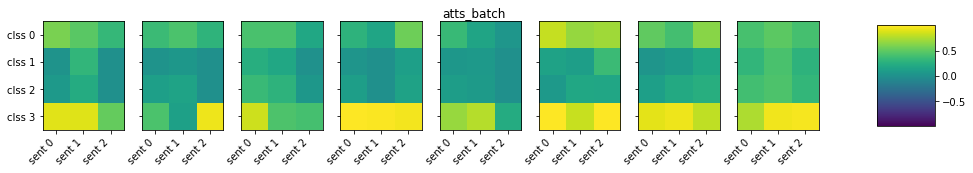

entity                                            logits             p  \
0    foo    [-4.879439, -7.253156, -5.7342124, -4.7515917]  [0, 0, 0, 0]   
1    foo    [-3.497848, -2.828271, 0.08150971, -2.9796383]  [0, 0, 1, 0]   
2    foo  [-0.17124534, 0.67863166, 0.97872007, -2.143546]  [0, 1, 1, 0]   
3    foo    [3.6295178, 0.76156545, 1.0886713, -0.8759825]  [1, 1, 1, 0]   
4    foo  [-3.5591822, -7.3049674, -4.9485993, -5.2744913]  [0, 0, 0, 0]   
5    foo   [-4.884267, -2.9515958, -4.7767525, -3.1762636]  [0, 0, 0, 0]   
6    foo  [-1.7981789, -2.4019718, -2.0095868, -3.2471414]  [0, 0, 0, 0]   
7    foo        [1.3053424, 1.1310444, 1.9552672, 4.13384]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

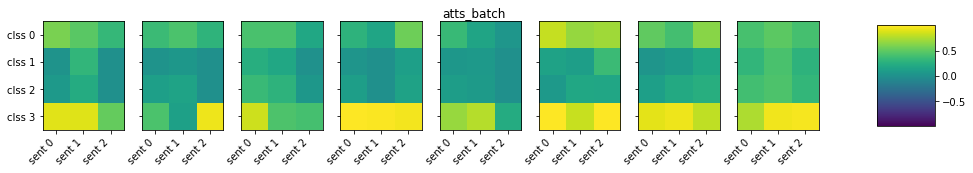

Epoch 40


entity                                              logits             p  \
0    foo           [-5.3062, -4.7046, -7.9663386, -6.895567]  [0, 0, 0, 0]   
1    foo     [-5.4786906, -10.16415, -15.680289, -7.1149545]  [0, 0, 0, 0]   
2    foo      [-2.538049, -4.7171445, -5.9512315, -3.652441]  [0, 0, 0, 0]   
3    foo     [-5.106047, -11.527771, -11.347199, -4.9892445]  [0, 0, 0, 0]   
4    foo      [-4.7461925, -6.369901, -11.967801, -6.736718]  [0, 0, 0, 0]   
5    foo  [-0.69201016, -0.72391427, -2.0496383, -2.2199912]  [0, 0, 0, 0]   
6    foo      [-2.8111792, -4.8006244, -11.411311, -5.42462]  [0, 0, 0, 0]   
7    foo      [-9.692079, -21.738003, -18.610157, -10.24394]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [1, 1, 1, 1]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               sents  
0                                                             [[he, was, the, coach, of, bonnie, blair, when, she, won, two, gold, medals, at, the, 1992, winter, olympics,, dan, jansen, when, he, won, gold, at, the, 1994, winter, olympics,, marianne, timmer, (two, gold, medals), and, jan, bos, (silver), at, the, 1998, winter, olympics,, and, gianni, romme, (silver), at, the, 2002, winter, olympics., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [curling, was, included, in, the, program, for, the, nagano, olympics, in, 1993, following, discussions, that, had, begun, in, 1992., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, 1992, winter, olympics, were, held, from, 8–23, february, 1992,, a, total, of, 1,801, athletes, representing, 64, national, olympic, committees, took, part., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                             [[old, airport, (;, also, referred, to, as, al, matar, al, qadeem), is, an, area, of, doha,, qatar., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>

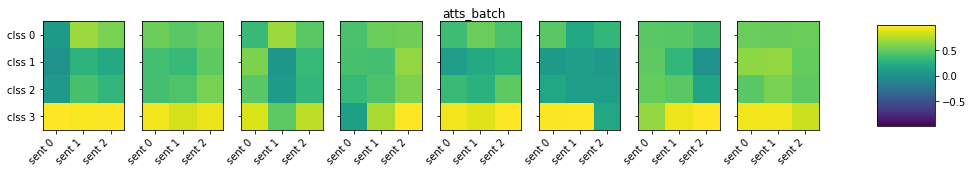

entity                                            logits             p  \
0    foo    [-5.0890865, -6.240265, -4.525965, -4.3821974]  [0, 0, 0, 0]   
1    foo  [-3.6780224, -2.5373247, 0.19076669, -2.5822167]  [0, 0, 1, 0]   
2    foo     [-0.17150044, 0.696396, 1.011133, -1.8959271]  [0, 1, 1, 0]   
3    foo     [3.3476222, 0.7535886, 1.0758557, -0.7595335]  [1, 1, 1, 0]   
4    foo   [-3.6078272, -6.768236, -4.1756015, -5.0999374]  [0, 0, 0, 0]   
5    foo   [-4.933147, -2.8117692, -4.4155636, -3.0240555]  [0, 0, 0, 0]   
6    foo   [-1.644425, -2.2080731, -1.7595235, -3.1246226]  [0, 0, 0, 0]   
7    foo       [1.6826315, 1.1445835, 1.9977087, 4.489786]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

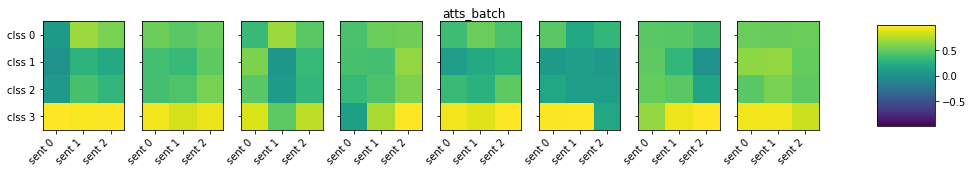

Epoch 41


entity                                              logits             p  \
0    foo      [-4.140252, -4.053711, -2.2321215, -5.0363455]  [0, 0, 0, 0]   
1    foo     [-1.7799044, -1.9078705, -1.4200131, -2.290602]  [0, 0, 0, 0]   
2    foo      [-1.490823, -1.890636, -1.6079234, -1.6007602]  [0, 0, 0, 0]   
3    foo     [-15.519261, -37.440224, -40.39101, -16.299273]  [0, 0, 0, 0]   
4    foo      [-8.650365, -15.95928, -18.986956, -7.3654747]  [0, 0, 0, 0]   
5    foo    [-1.4783058, -1.2196355, -1.6584026, -2.3493874]  [0, 0, 0, 0]   
6    foo       [-14.0357, -18.002327, -20.620842, -9.026419]  [0, 0, 0, 0]   
7    foo  [-0.75412774, -0.6754029, -0.77373445, -2.5058212]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 1, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   sents  
0                                            [[for, her, performances, in, the, second, seasons, of, killing, eve, and, the, comedy-drama, fleabag,, shaw, received, primetime, emmy, award, nominations, for, outstanding, supporting, actress, in, a, drama, series, and, outstanding, guest, actress, in, a, comedy, series, respectively., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [she, wrote, the, screenplay, for, the, film, version, of, postcards, from, the, edge, which, garnered, her, a, bafta, award, for, best, adapted, screenplay, nomination,, and, her, one-woman, stage, show, of, wishful, drinking, was, filmed, for, television, and, received, a, nomination, for, the, primetime, emmy, award, for, outstanding, variety, special., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, following, year, fey, won, an, emmy, in, the, category, of, outstanding, guest, actress, in, a, comedy, series, for, her, impersonation, of, palin., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                                                             [[the, trios, had, multiple, vignettes, where, they, sit, in, circle, as, smoke, surrounded, them,, similar, to, a, popular, segment, from, that, '70s, show., <unk

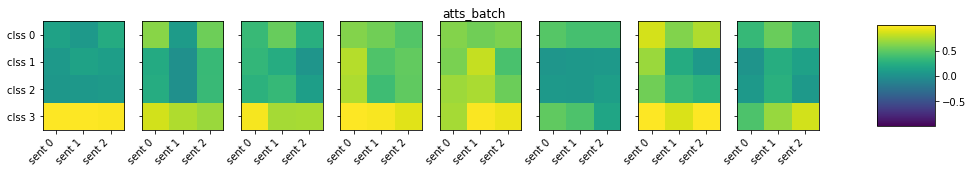

entity                                             logits             p  \
0    foo      [-5.093549, -5.198597, -4.571539, -4.6554184]  [0, 0, 0, 0]   
1    foo     [-3.567852, -1.7026794, 0.37945318, -2.766418]  [0, 0, 1, 0]   
2    foo  [-0.0120539665, 0.8158448, 1.1619489, -1.8476329]  [0, 1, 1, 0]   
3    foo     [4.2850533, 0.8404081, 1.1511692, -0.56867456]  [1, 1, 1, 0]   
4    foo    [-3.5774226, -6.4525585, -3.857853, -5.3806314]  [0, 0, 0, 0]   
5    foo   [-4.9415016, -2.5728111, -4.3195963, -3.1935816]  [0, 0, 0, 0]   
6    foo   [-1.6629679, -2.0493386, -1.5976868, -3.2433147]  [0, 0, 0, 0]   
7    foo         [1.7816613, 1.1936471, 2.051626, 4.495531]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, rando

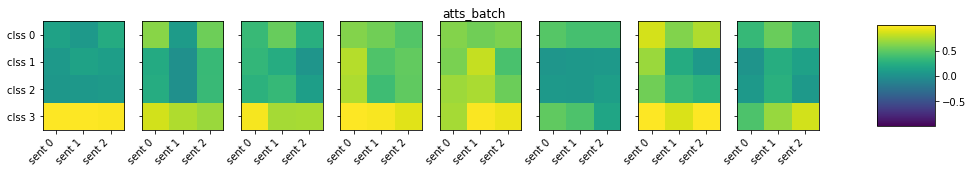

Epoch 42


entity                                            logits             p  \
0    foo  [-1.5461044, -0.9943435, -1.0744042, -2.3978705]  [0, 0, 0, 0]   
1    foo    [-7.1764345, -8.643656, -14.953916, -8.449344]  [0, 0, 0, 0]   
2    foo  [-1.5171326, -1.7418344, -3.2834625, -2.0676847]  [0, 0, 0, 0]   
3    foo    [-4.784042, -5.821088, -11.8040085, -6.316353]  [0, 0, 0, 0]   
4    foo   [-3.0424418, -3.8045986, -5.731281, -4.1716948]  [0, 0, 0, 0]   
5    foo   [-3.7875948, -4.0187454, -7.2859926, -4.133056]  [0, 0, 0, 0]   
6    foo      [-3.56659, -4.476511, -4.609581, -5.0464892]  [0, 0, 0, 0]   
7    foo   [-1.3393701, -2.2544541, -2.3827734, -2.940865]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        sents  
0                              [[however,, their, scene, got, cut, from, the, final, film, as, it, was, deemed, unnecessary., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, dvd, also, contains, deleted, and, extended, scenes,, a, blooper, reel,, visual, effects, progressions,, a, set, tour, with, fillion,, and, an, audio, commentary, by, gunn, and, fillion., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [in, a, scene, deleted, from, the, final, episode,, president, laura, roslin, is, shown, coming, up, with, the, idea, of, inviting, biers, to, galactica., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                           [[these, years, included, an, fa, cup, third, round, appearance, in, 1961–62,, a, 1–0, defeat, to, weymouth;, a, lancashire, senior, cup, final, victory, in, 1968,, a, 2–1, win, over, burnley, and, an, fa, trophy, success, at, wembley, in, 1974,, a, 2–1, win, over, dartford, in, the, final., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, 

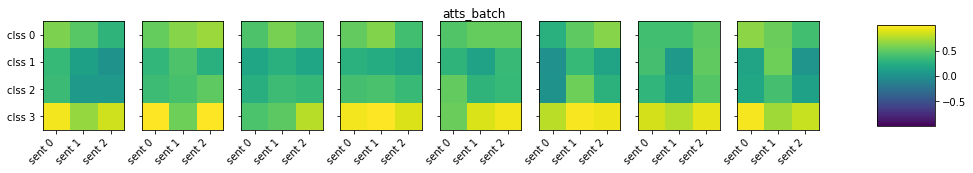

entity                                             logits             p  \
0    foo    [-4.723864, -6.8400793, -5.3219633, -4.4652166]  [0, 0, 0, 0]   
1    foo  [-3.5226316, -3.3643868, 0.042087793, -2.8039453]  [0, 0, 1, 0]   
2    foo  [-0.031258345, 0.66383946, 0.9735863, -2.1314383]  [0, 1, 1, 0]   
3    foo      [3.8138788, 0.7377118, 1.0305318, -1.0358803]  [1, 1, 1, 0]   
4    foo    [-3.4054842, -7.0597124, -4.446368, -5.1682153]  [0, 0, 0, 0]   
5    foo   [-4.7847433, -3.0403364, -4.6474476, -3.0650282]  [0, 0, 0, 0]   
6    foo   [-1.5696678, -2.3555572, -1.8599374, -3.2237334]  [0, 0, 0, 0]   
7    foo        [1.4231503, 1.1567237, 1.9900959, 4.299265]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, rando

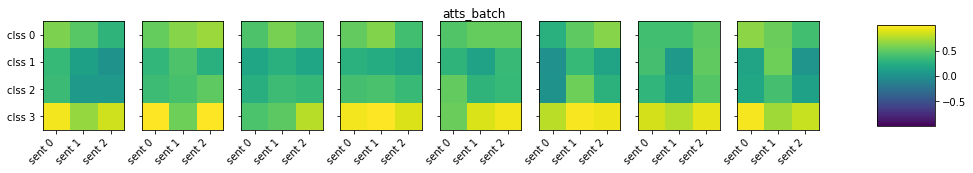

Epoch 43


entity                                            logits             p  \
0    foo   [-1.2262425, -2.029567, -1.0417869, -2.3045595]  [0, 0, 0, 0]   
1    foo  [1.858371, 0.095200896, -1.3061967, -0.04379344]  [1, 1, 0, 0]   
2    foo        [-3.41857, -6.789809, -8.221064, -4.45485]  [0, 0, 0, 0]   
3    foo     [2.4891798, 0.7428616, 0.7674321, -1.2226022]  [1, 1, 1, 0]   
4    foo    [-5.700117, -11.989506, -5.7551174, -6.380577]  [0, 0, 0, 0]   
5    foo    [-6.735812, -15.685123, -19.369934, -7.391593]  [0, 0, 0, 0]   
6    foo   [-2.583243, -1.2828524, -3.7575443, -3.7222438]  [0, 0, 0, 0]   
7    foo   [-5.2972174, -7.4465904, -8.461908, -7.5044584]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [1, 1, 0, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 0, 1]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     sents  
0                                                                   [[allmusic, reviewer, richie, unterberger, wrote, of, the, album:, "about, half, of, this, is, run-of-the-mill, pseudo-'60s, garage/psych, with, too, many, indulgent, guitar, breaks., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [estrus, records, is, an, independent, record, label, from, bellingham,, washington, that, makes, surf,, garage, and, trash, rock, music., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, black, belles, is, an, american, all-female, "garage, goth", rock, band, found, by, jack, white, and, signed, to, his, label, third, man, records., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                         [[produced, by, ánima, estudios,, prime, focus, world,, and, gfm, animation,, the, film, features, the, voices, of, toby, kebbell,, lily, collins,, and, ian, mcshane., <unk>, <unk>,

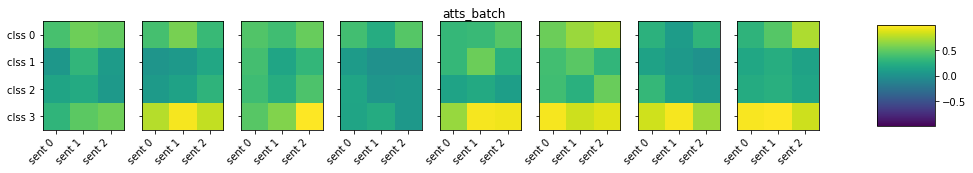

entity                                           logits             p  \
0    foo   [-5.10081, -5.5800524, -4.7680902, -4.7400427]  [0, 0, 0, 0]   
1    foo   [-3.578152, -2.021228, 0.21817899, -2.8500412]  [0, 0, 1, 0]   
2    foo  [-0.24940443, 0.7809974, 1.0684927, -1.7854074]  [0, 1, 1, 0]   
3    foo   [3.7257297, 0.80051833, 1.108088, -0.59524524]  [1, 1, 1, 0]   
4    foo  [-3.5868444, -6.4011393, -4.0646544, -5.453457]  [0, 0, 0, 0]   
5    foo  [-4.901284, -2.5969458, -4.4517536, -3.2137232]  [0, 0, 0, 0]   
6    foo  [-1.6118684, -1.9861784, -1.614353, -3.2892709]  [0, 0, 0, 0]   
7    foo        [1.7679408, 1.1717675, 2.05559, 4.380204]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and, rachael

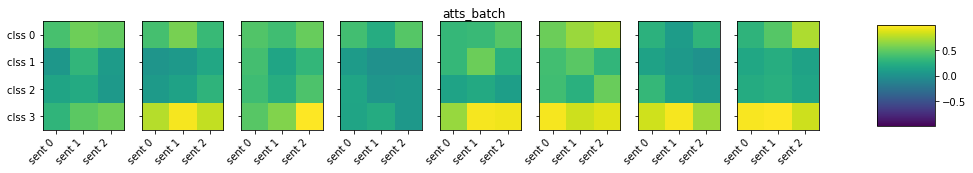

Epoch 44


entity                                             logits             p  \
0    foo     [-7.243655, -10.794264, -8.383394, -7.1630344]  [0, 0, 0, 0]   
1    foo    [-4.9773397, -6.2147903, -5.5904074, -6.457636]  [0, 0, 0, 0]   
2    foo    [-2.8203735, -3.4041562, -4.350127, -4.5788403]  [0, 0, 0, 0]   
3    foo   [-6.9958916, -22.708351, -16.719126, -10.457953]  [0, 0, 0, 0]   
4    foo      [-5.767889, -4.1842833, -7.637042, -7.024375]  [0, 0, 0, 0]   
5    foo      [-6.072568, -9.968633, -7.812995, -5.7713156]  [0, 0, 0, 0]   
6    foo   [-3.9798741, -2.9738932, -2.865319, -0.71265674]  [0, 0, 0, 0]   
7    foo  [-1.6556687, -1.2557755, -0.68121743, -1.6730952]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             sents  
0  [[first, hispanic, american, male, judge, in, wisconsin, (2008), <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [further, information:, list, of, wisconsin, magazines, and, list, of, wisconsin, daily, newspapers, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [as, a, research, center,, the, medical, college, of, wisconsin, received, more, than, $154, million, in, external, support, for, research,, teaching,, training, and, related, purposes, in, fiscal, year, (fy), 2013–2014., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                                                                [[she, is, a, recipient, of, the, world, fantasy, award—novel., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>,

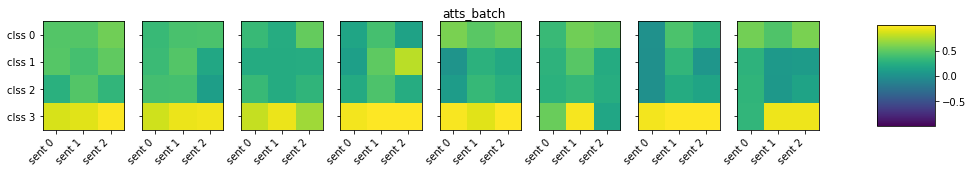

entity                                           logits             p  \
0    foo   [-5.111182, -6.638156, -5.2623587, -4.8812966]  [0, 0, 0, 0]   
1    foo  [-3.733496, -2.9775383, -0.05022931, -3.067738]  [0, 0, 0, 0]   
2    foo  [-0.34765303, 0.6462012, 0.9131905, -2.3728426]  [0, 1, 1, 0]   
3    foo   [3.6355934, 0.73907256, 1.0443604, -0.9302093]  [1, 1, 1, 0]   
4    foo  [-3.6204228, -7.498459, -4.3571844, -5.4656706]  [0, 0, 0, 0]   
5    foo  [-5.013753, -2.9307113, -4.6224174, -3.1936998]  [0, 0, 0, 0]   
6    foo  [-1.724164, -2.3401294, -1.7523458, -3.2785177]  [0, 0, 0, 0]   
7    foo      [1.3501081, 1.1533657, 2.0253122, 4.061757]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and, rachael

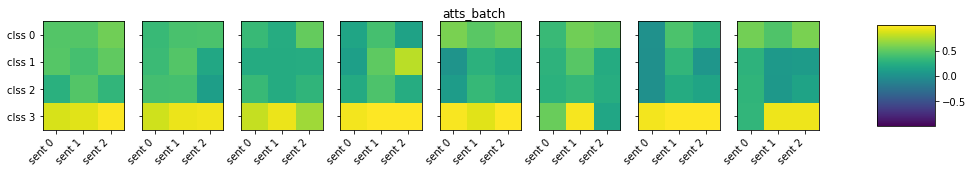

Epoch 45


entity                                               logits             p  \
0    foo       [-0.42965126, 0.8880001, 1.0071609, 1.8077824]  [0, 1, 1, 1]   
1    foo        [2.1478124, 0.40212852, 0.7690091, 1.1853545]  [1, 1, 1, 1]   
2    foo  [-0.23663247, 0.07309389, -0.008831501, -0.5878948]  [0, 1, 0, 0]   
3    foo   [-0.40241373, -0.28312016, -0.79878163, -1.228225]  [0, 0, 0, 0]   
4    foo          [-3.081513, -4.4859133, -5.1398, -3.669757]  [0, 0, 0, 0]   
5    foo     [-1.2492937, -4.2331924, -3.4354737, -2.6397796]  [0, 0, 0, 0]   
6    foo   [-0.24885297, -0.44456995, -0.24169469, -5.076307]  [0, 0, 0, 0]   
7    foo      [-2.3313046, -1.3046215, -2.4286015, -2.427795]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 1, 1]   
1  [1, 1, 1, 1]   
2  [1, 1, 1, 1]   
3  [1, 0, 0, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [1, 0, 1, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          sents  
0  [[the, film, stars, johnny, simmons,, maria, bello,, brittany, snow,, jane, lynch,, j., k., simmons,, kumail, nanjiani,, beck, bennett,, and, paul, wesley,, and, is, based, on, journalist, ken, baker's, autobiography, man, made:, a, memoir, of, my, body,, in, which, he, detailed, experiencing, puberty, for, the, first, time, at, age, 27., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [in, may, 2014,, maria, bello, and, mike, doyle, joined, the, cast, as, molly, and, jim, mcgrath,, max's, parents., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [also, inducted, into, the, club, are, sylvia, (amy, brenneman),, a, fortysomething, librarian, recently, separated, from, her, philandering, lawyer, husband, daniel, (jimmy, smits), after, over, two, decades, of, marriage;, sylvia's, 20-something, lesbian, daughter, allegra, (maggie, grace);, jocelyn, (maria, bello),, a, happily, unmarried, control, freak, and, breeder, of, rhodesian, ridgebacks,, and, sylvia's, friend, since, childhood;, and, grigg, (hugh, dancy),, a, science, fiction, fan, invited, into, the]]  
1                                                                   [[he, was, voiced, by, brad, garrett, in, disney's, 1998, direct-to-video, film, pocahontas, ii:, journey, to, a, new, world., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>

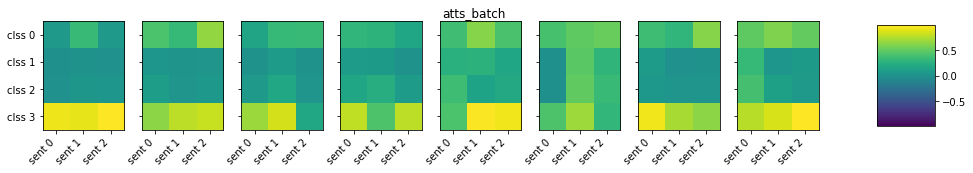

entity                                            logits             p  \
0    foo      [-5.136254, -6.31855, -4.2323246, -4.550725]  [0, 0, 0, 0]   
1    foo   [-3.6822472, -2.5855546, 0.5324974, -2.7650523]  [0, 0, 1, 0]   
2    foo  [0.054317474, 0.70164037, 1.1930798, -2.1380944]  [1, 1, 1, 0]   
3    foo    [4.6977696, 0.7243229, 1.1568224, -0.88556886]  [1, 1, 1, 0]   
4    foo    [-3.5901296, -6.958238, -3.6262238, -5.231077]  [0, 0, 0, 0]   
5    foo  [-4.9604306, -2.8533196, -4.2574406, -3.1024098]  [0, 0, 0, 0]   
6    foo   [-1.6224865, -2.2228608, -1.5071764, -3.191781]  [0, 0, 0, 0]   
7    foo       [1.9830761, 1.1351138, 2.089129, 4.4337683]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

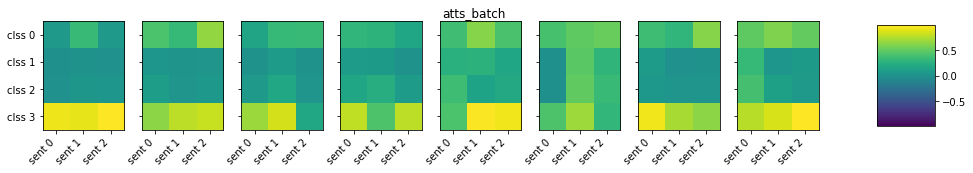

Epoch 46


entity                                                logits             p  \
0    foo        [-3.1520255, -4.267203, -8.522361, -5.4195347]  [0, 0, 0, 0]   
1    foo       [-1.0053561, -1.0904231, -1.685508, -2.2500792]  [0, 0, 0, 0]   
2    foo          [0.9379444, -1.467741, -4.45487, -1.6301589]  [1, 0, 0, 0]   
3    foo       [-4.742886, -2.5379012, -1.8468997, -5.3922806]  [0, 0, 0, 0]   
4    foo       [3.4997687, 1.2919989, 2.4420142, 0.0021998882]  [1, 1, 1, 1]   
5    foo       [-4.7245035, -3.295722, -5.8974676, -5.0078406]  [0, 0, 0, 0]   
6    foo        [-6.9543376, -8.990095, -16.751892, -11.41035]  [0, 0, 0, 0]   
7    foo  [-0.038262844, -1.7269356, -0.045492887, -1.8711157]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [0, 0, 0, 0]   
4  [1, 1, 1, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 1, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 sents  
0                [[the, original, 16th-century, bridge, was, the, oldest, bridge, in, vilnius., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [he, was, one, of, 32, lithuanians, arrested, in, january, 1922, and, expelled, formally, a, month, later, by, decision, of, aleksander, meysztowicz,, president, of, central, lithuania, provisional, government,, from, vilnius, and, handed, over, to, lithuanian, army., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [it, is, located, north, of, vilnius,, on, the, road, vilnius–molėtai., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                          [[designated, hitter, rusty, staub, also, had, a, .278, batting, average,, 173, hits,, 22, home, runs,, and, 101, rbis., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <un

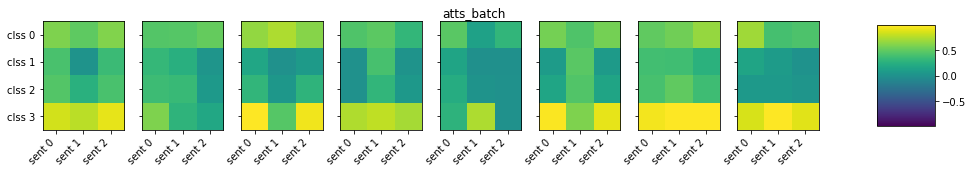

entity                                            logits             p  \
0    foo   [-4.9766083, -6.505604, -6.0168376, -4.7722197]  [0, 0, 0, 0]   
1    foo  [-3.6189904, -2.558155, -0.14677858, -3.0491445]  [0, 0, 0, 0]   
2    foo  [-0.43847156, 0.7458308, 0.82140887, -2.4201136]  [0, 1, 1, 0]   
3    foo     [3.2917168, 0.764541, 1.0205506, -0.99567986]  [1, 1, 1, 0]   
4    foo    [-3.5183725, -7.122206, -4.8372865, -5.386239]  [0, 0, 0, 0]   
5    foo    [-4.9113855, -2.686801, -4.716102, -3.1448016]  [0, 0, 0, 0]   
6    foo  [-1.6379294, -2.2422194, -1.8905587, -3.2425003]  [0, 0, 0, 0]   
7    foo      [1.1976049, 1.1734508, 2.0197105, 4.1063814]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

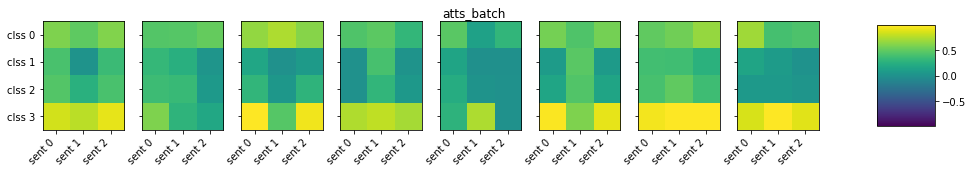

Epoch 47


entity                                             logits             p  \
0    foo    [-4.4041414, -5.261381, -5.4480042, -3.6236768]  [0, 0, 0, 0]   
1    foo     [-4.755677, -7.6675286, -6.2084594, -4.732362]  [0, 0, 0, 0]   
2    foo   [-1.4116014, -1.7239083, -0.8727467, -3.4105759]  [0, 0, 0, 0]   
3    foo  [-0.20141673, -0.17035139, -1.733666, -3.1279626]  [0, 0, 0, 0]   
4    foo     [-3.5868974, -4.9733434, -11.71517, -4.058011]  [0, 0, 0, 0]   
5    foo      [-4.468216, -6.033461, -11.068445, -4.121132]  [0, 0, 0, 0]   
6    foo      [-0.36369956, 0.9225104, 1.060607, 2.3742936]  [0, 1, 1, 1]   
7    foo     [-4.019074, -5.8535066, -7.3736644, -4.484272]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 1, 1, 1]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    sents  
0                      [[a, partnership, with, vivendi, games,, in, 2006,, regarding, the, release, of, scarface:, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, business, continued, to, operate, as, a, division, of, vivendi, games., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [zembillas, had, previously, designed, crash, for, naughty, dog,, whose, offices, were, just, across, the, hall, from, insomniac's, at, universal, interactive, studios., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                     [[as, a, result,, some, popular, games, which, use, the, havok, engine, have, not, yet, been, ported, to, the, macintosh., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk

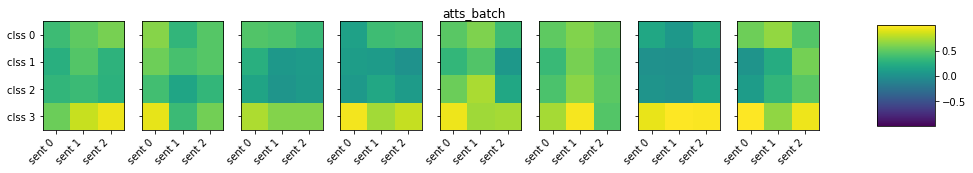

entity                                            logits             p  \
0    foo      [-4.8517494, -5.8568, -5.094448, -5.0370045]  [0, 0, 0, 0]   
1    foo  [-3.4850268, -2.1689644, 0.29872453, -3.1059475]  [0, 0, 1, 0]   
2    foo   [0.033115864, 0.7326653, 1.0347562, -2.5475676]  [1, 1, 1, 0]   
3    foo    [4.3463974, 0.79669684, 1.1580758, -0.8275695]  [1, 1, 1, 0]   
4    foo  [-3.4862082, -6.9147253, -4.4044657, -5.6450844]  [0, 0, 0, 0]   
5    foo    [-4.800279, -2.6127613, -4.3378267, -3.288437]  [0, 0, 0, 0]   
6    foo   [-1.5438569, -2.130274, -1.7521746, -3.3296022]  [0, 0, 0, 0]   
7    foo       [2.0831769, 1.1771002, 2.0797653, 4.140565]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

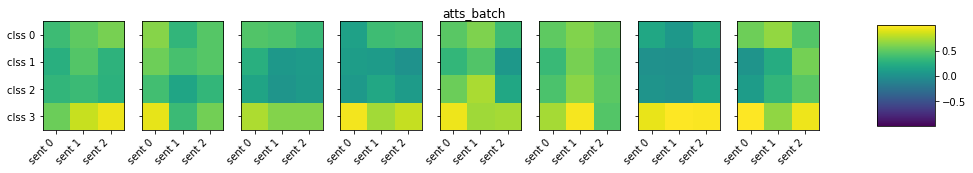

Epoch 48


entity                                             logits             p  \
0    foo  [-11.263295, -13.4248295, -34.661503, -16.534369]  [0, 0, 0, 0]   
1    foo    [-1.8982267, -2.5091727, -4.5886097, -3.710163]  [0, 0, 0, 0]   
2    foo      [1.4387779, 0.3336959, 1.2019236, -1.8359193]  [1, 1, 1, 0]   
3    foo     [1.8908012, 0.82132345, -3.2274334, 1.5263126]  [1, 1, 0, 1]   
4    foo     [-6.6036663, -8.283045, -7.596491, -4.8545904]  [0, 0, 0, 0]   
5    foo    [-4.2649612, -3.8449285, -6.160507, -5.5634212]  [0, 0, 0, 0]   
6    foo       [-3.9561071, -5.477641, -6.34923, -4.575652]  [0, 0, 0, 0]   
7    foo     [-9.274461, -7.827301, -5.3030434, -4.6992497]  [0, 0, 0, 0]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 0, 0]   
2  [1, 1, 1, 0]   
3  [1, 0, 0, 1]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [0, 0, 0, 0]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               sents  
0    [[these, include, camberwell, college, of, arts,, central, saint, martins,, chelsea, college, of, arts,, london, college, of, communication,, london, college, of, fashion,, and, wimbledon, college, of, arts;, others, include, the, slade, school, of, fine, art,, the, royal, college, of, art, and, goldsmiths, college,, university, of, london,, which, each, grant, undergraduate, and, postgraduate, awards, under, one, collegiate, arm., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [before, receiving, her, ba, honors, degree, from, the, chelsea, school, of, art, in, london,, she, completed, her, foundation, education, in, art, from, brighton, polytechnic., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [after, teaching, transferred, to, the, queen, alexandra, hospital, in, cosham, near, portsmouth, in, 1999,, the, college, closed, and, the, buildings, are, now, occupied, by, the, chelsea, college, of, arts., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1                                                                   [[ynaija, wrote:, "celia, puts, tiwa, in, a, new, political, world,, one, that, honours, [her], predecessors, –, and, its, pool, of, bubblegum, tracks, but, pushes, for, a, closer, examination, of, womanhood., <unk>, <unk>, <unk>, <unk>, 

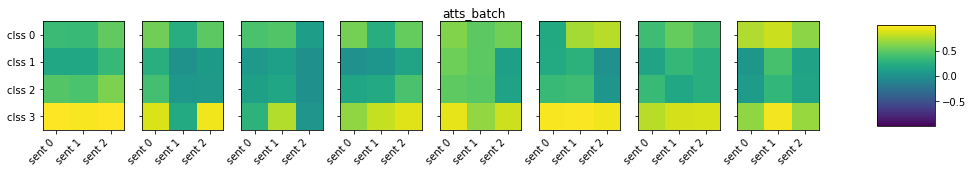

entity                                            logits             p  \
0    foo      [-5.190551, -6.0237937, -4.816866, -4.77549]  [0, 0, 0, 0]   
1    foo   [-3.736321, -2.4396486, 0.20507526, -2.9458134]  [0, 0, 1, 0]   
2    foo     [-0.5000937, 0.761354, 1.1043125, -2.3741343]  [0, 1, 1, 0]   
3    foo      [3.4368763, 0.7822738, 1.1415417, -0.930807]  [1, 1, 1, 0]   
4    foo  [-3.6000354, -6.8518705, -3.9300637, -5.4537706]  [0, 0, 0, 0]   
5    foo  [-5.0445576, -2.5919604, -4.2910743, -3.1755595]  [0, 0, 0, 0]   
6    foo  [-1.7875944, -2.1447492, -1.5645514, -3.2515867]  [0, 0, 0, 0]   
7    foo      [1.0847807, 1.1688669, 2.0928578, 4.3931065]  [1, 1, 1, 1]   

             gt  \
0  [0, 0, 0, 0]   
1  [0, 0, 1, 1]   
2  [0, 0, 0, 0]   
3  [1, 0, 1, 0]   
4  [0, 0, 0, 0]   
5  [0, 0, 0, 0]   
6  [0, 0, 0, 0]   
7  [1, 0, 1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      sents  
0                                              [[at, one, new, york, show, they, were, discovered, by, an, a&m, records, talent, scout,, patrick, clifford,, and, the, band, signed, their, first, recording, contract., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [although, this, song, entered, the, country, charts,, the, album, itself, was, not, released, due, to, the, closure, of, <unk>, nashville, unit., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>], [the, song, gained, success, shortly, after, styx, left, wooden, nickel, records, to, move, to, a&m, records, in, 1974, as, it, began, picking, up, airplay, <unk>, at, the, 2010, great, jones, county, fair, eventually, peaking, at, #6, on, the, billboard, hot, 100, in, march, 1975., <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>, <unk>]]  
1  [[after, discovering, he, is, an, unsuitable, donor, by, dr., leo, <unk>, (chris, <unk>, jack, uses, his, <unk>, clay, aiken,, sara, bareilles,, the, beastie, boys, (mike, d, and, <unk>, mary, j., blige,, elvis, costello,, sheryl, crow,, steve, earle,, wyclef, jean,, norah, jones,, talib, kweli,, cyndi, lauper,, adam, levine,, michael, mcdonald,, rhett, miller,, moby,, robert, randolph,, and

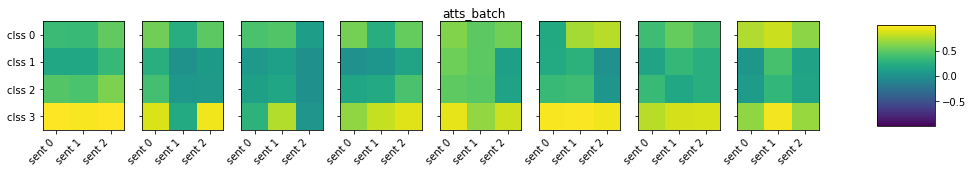

Epoch 49


In [5]:
# criterion = MSELoss()
criterion = BCEWithLogitsLoss()
# criterion = BCEWithLogitsLoss(pos_weight=torch.tensor([class_weight] * class_count))

# optimizer = SGD(classifier.parameters(), lr=lr)
optimizer = Adam(classifier.parameters(), lr=lr)

writer = SummaryWriter(log_dir=log_dir)

for epoch in range(epoch_count):

    #
    # Train
    #

    # Train loss across all batches
    train_loss = 0.0

    # Valid gt/pred classes across all batches
    train_gt_classes_stack: List[List[int]] = []
    train_pred_classes_stack: List[List[int]] = []

    for batch_idx, (sents_batch, gt_classes_batch,) in enumerate(train_loader):
        debug['enabled'] = (batch_idx == 0)
        logits_batch = classifier(sents_batch)

        loss = criterion(logits_batch, gt_classes_batch.float())
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred_classes_batch = (logits_batch > 0).int()

        train_gt_classes_stack += gt_classes_batch.numpy().tolist()
        train_pred_classes_stack += pred_classes_batch.numpy().tolist()
        
        #
        # Print first batch
        #

        if batch_idx == 0:

            dlb = logits_batch.detach().numpy()  # logits batch
            dpb = pred_classes_batch.detach().numpy()  # predicted classes batch
            dgb = gt_classes_batch.detach().numpy()  # ground truth classes batch
            dsb = sents_batch.detach().numpy()  # sentences batch

            df_cols = ['entity', 'logits', 'p', 'gt', 'sents']
            df_data = [('foo', logits, pred_classes, classes, [[vocab.itos[tok] for tok in sent] for sent in sents])
                       for logits, pred_classes, classes, sents in zip(dlb, dpb, dgb, dsb)]

            df = pd.DataFrame(df_data[:8], columns=df_cols)
            display(df)

            display_atts = debug['atts_batch'][:8]
            ent_labels = [f'ent {i}' for i in range(batch_size)]
            class_labels = [f'clss {i}' for i in range(class_count)]
            sent_labels = [f'sent {i}' for i in range(sent_count)]
            plot_tensor(display_atts, 'atts_batch', [ent_labels, class_labels, sent_labels])

    #
    # Validate
    #

    # Valid loss across all batches
    valid_loss = 0.0

    # Valid gt/pred classes across all batches
    valid_gt_classes_stack: List[List[int]] = []
    valid_pred_classes_stack: List[List[int]] = []

    with torch.no_grad():
        for batch_idx, (sents_batch, gt_classes_batch) in enumerate(valid_loader):
            logits_batch = classifier(sents_batch)

            loss = criterion(logits_batch, gt_classes_batch.float())
            valid_loss += loss.item()

            pred_classes_batch = (logits_batch > 0).int()

            valid_gt_classes_stack += gt_classes_batch.numpy().tolist()
            valid_pred_classes_stack += pred_classes_batch.numpy().tolist()

            #
            # Print first batch
            #

            if batch_idx == 0:

                dlb = logits_batch.detach().numpy()  # logits batch
                dpb = pred_classes_batch.detach().numpy()  # predicted classes batch
                dgb = gt_classes_batch.detach().numpy()  # ground truth classes batch
                dsb = sents_batch.detach().numpy()  # sentences batch

                df_cols = ['entity', 'logits', 'p', 'gt', 'sents']
                df_data = [('foo', logits, pred_classes, classes, [[vocab.itos[tok] for tok in sent] for sent in sents])
                           for logits, pred_classes, classes, sents in zip(dlb, dpb, dgb, dsb)]

                df = pd.DataFrame(df_data[:8], columns=df_cols)
                display(df)

                display_atts = debug['atts_batch'][:8]
                ent_labels = [f'ent {i}' for i in range(batch_size)]
                class_labels = [f'clss {i}' for i in range(class_count)]
                sent_labels = [f'sent {i}' for i in range(sent_count)]
                plot_tensor(display_atts, 'atts_batch', [ent_labels, class_labels, sent_labels])

    #
    # Log
    #

    print(f'Epoch {epoch}')

    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)

    writer.add_scalars('loss', {'train': train_loss, 'valid': valid_loss}, epoch)

    # tps = train precisions, vps = valid precisions, etc.
    tps = precision_score(train_gt_classes_stack, train_pred_classes_stack, average=None)
    vps = precision_score(valid_gt_classes_stack, valid_pred_classes_stack, average=None)
    trs = recall_score(train_gt_classes_stack, train_pred_classes_stack, average=None)
    vrs = recall_score(valid_gt_classes_stack, valid_pred_classes_stack, average=None)
    tfs = f1_score(train_gt_classes_stack, train_pred_classes_stack, average=None)
    vfs = f1_score(valid_gt_classes_stack, valid_pred_classes_stack, average=None)

    # for i, (tp, vp, tr, vr, tf, vf) in enumerate(zip(tps, vps, trs, vrs, tfs, vfs)):
    #     writer.add_scalars('precision', {f'train {i}': tp, f'valid {i}': vp}, epoch)
    #     writer.add_scalars('recall', {f'train {i}': tr, f'valid {i}': vr}, epoch)
    #     writer.add_scalars('f1', {f'train {i}': tf, f'valid {i}': vf}, epoch)

    mean_train_precision = tps.mean()
    mean_valid_precision = vps.mean()
    mean_train_recall = trs.mean()
    mean_valid_recall = vrs.mean()
    mean_train_f1 = tfs.mean()
    mean_valid_f1 = vfs.mean()

    writer.add_scalars('precision', {f'train': mean_train_precision, f'valid': mean_valid_precision}, epoch)
    writer.add_scalars('recall', {f'train': mean_train_recall, f'valid': mean_valid_recall}, epoch)
    writer.add_scalars('f1', {f'train': mean_train_f1, f'valid': mean_valid_f1}, epoch)

# 4 Test

## 4.1 Define test data

In [6]:
test_data = [
    {
        'ent': 1000,
        'classes': [1, 0, 1, 0],  # married, male, American, actor
        'sents': [
            'Michelle is married',
            'Michelle is female',
            'Michelle is American'
        ]
    },
    {
        'ent': 2000,
        'classes': [1, 0, 0, 0],  # married, male, American, actor
        'sents': [
            'Angela is married',
            'Angela is female',
            'Angela is German'
        ]
    }
]

def tokenize(text: str) -> List[str]:
    return text.split()

test_set = [Sample(
    item['ent'],
    item['classes'],
    [[vocab[word] for word in tokenize(sent)] for sent in item['sents']]
) for item in test_data]

test_loader = DataLoader(test_set, batch_size=len(test_set), collate_fn=generate_batch)

## 4.2 Forward test batch

In [7]:
test_loss = 0.0
with torch.no_grad():
    for sents_batch, classes_batch in test_loader:
        logits_batch = classifier(sents_batch)

        print(logits_batch)

        loss = criterion(logits_batch, classes_batch.float())
        test_loss += loss.item()

test_loss /= len(test_loader)

print(f'Test loss = {test_loss}')

tensor([[-2.7145, -0.4194,  1.1042, -1.6615],
        [-2.7145, -0.4194,  1.1042, -1.6615]])
Test loss = 1.074036717414856
